# <div style="background: #4a5759 ; padding: 30px; border-radius: 15px; margin: 20px 0;"><h1 style="color: #edafb8; text-align: center; margin: 0; font-size: 2.5em;">🎯 Beyond Accuracy</h1><h3 style="color: #edafb8; text-align: center; margin: 10px 0 0 0; font-weight: 300;">Understanding Model Decisions Through SHAP Analysis</h3></div>

## 💡 Introduction

A high performing machine learning model may seem perfect at first glance. You check accuracy, AUC, and F1-score, conduct cross validation, and everything appears to align. However, sometimes this seemingly flawless model can conceal bias. Performance metrics alone tell only part of the story.

### What You'll Learn in This Notebook:

1. How to validate model decisions beyond traditional metrics
2. Identifying feature dominance patterns using SHAP
3. Detecting potential biases in credit risk models
4. Testing model fragility through systematic analysis
5. Best practices for trustworthy ML model validation

### Tools & Techniques:

- **Dataset**: LendingClub Loan Data (50k samples)
- **Models**: XGBoost, CatBoost, Random Forest  
- **Analysis**: SHAP global importance, dependence plots, fragility testing
- **Focus**: Understanding why models make decisions, not just how well they perform

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">📚 Table of Contents</div>

1. [📥 Data Loading](#1)
2. [📊 Exploratory Data Analysis](#2)
3. [🔧 Data Preprocessing](#3)
4. [🤖 Model Trainin](#4)
5. [🔍 SHAP Analysis](#5)
6. [📈 SHAP Dependence Plots](#6)
7. [⚠️ Data Leakage Detection](#7)
8. [🧪 Fragility Testing](#8)
9. [🎓 Bias Detection](#9)
10. [🎯 Conclusion](#10)
 

This notebook explores the concepts of model explainability. We'll go beyond accuracy to understand why models make certain predictions. We will also learn how to ensure they're not quietly reproducing biases from the data.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix

# Gradient Boosting Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Explainability
import shap

# Color Palette
palette = ['#edafb8', '#dedbd2', '#b0c4b1', '#4a5759']
sns.set_palette(palette)
sns.set(rc={"axes.facecolor":"#f7e1d7","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap(palette)
%matplotlib inline


<a id="1"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">📥 1. Data Loading</div>

Let's start by loading the LendingClub dataset. We'll use stratified sampling to ensure balanced class representation.


In [2]:
# Load data
df = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz', low_memory=False)
print(f"Loaded dataset with shape: {df.shape}")

# Filter to completed loans only
completed_statuses = [
    'Fully Paid', 'Charged Off', 'Default', 
    'Late (31-120 days)', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status: Charged Off'
]

df = df[df['loan_status'].isin(completed_statuses)].copy()
print(f"Filtered to completed loans: {df.shape[0]:,} rows")

# Show distribution
print("\nLoan status distribution:")
print(df['loan_status'].value_counts())

# Binary target for stratified sampling
target_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 
    'Does not meet the credit policy. Status:Fully Paid': 0,  
    'Does not meet the credit policy. Status: Charged Off': 1
}
temp_target = df['loan_status'].map(target_map)

# Stratified sampling (up to 50k)
sample_size = min(50000, len(df))
df, _ = train_test_split(df, train_size=sample_size, stratify=temp_target, random_state=42)

print(f"\nFinal sampled dataset: {df.shape}")


Loaded dataset with shape: (2260701, 151)
Filtered to completed loans: 1,373,154 rows

Loan status distribution:
loan_status
Fully Paid                                            1076751
Charged Off                                            268559
Late (31-120 days)                                      21467
Late (16-30 days)                                        4349
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                    40
Name: count, dtype: int64

Final sampled dataset: (50000, 151)


In [3]:
# Convert loan_status to binary (0=paid, 1=default)
status_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
}

print("\nBinary mapping:")
print("  0: Paid (Fully Paid, Policy-Fully Paid)")
print("  1: Default (Charged Off, Default, Late, Policy-Charged Off)")

df['loan_status_binary'] = df['loan_status'].map(status_map).astype(int)

# Class distribution
class_dist = df['loan_status_binary'].value_counts().sort_index()

print(f"\nClass distribution:")
for cls, count in class_dist.items():
    label = "Paid" if cls == 0 else "Default"
    print(f"  {cls} ({label}): {count:,} ({count/len(df)*100:.1f}%)")



Binary mapping:
  0: Paid (Fully Paid, Policy-Fully Paid)
  1: Default (Charged Off, Default, Late, Policy-Charged Off)

Class distribution:
  0 (Paid): 39,280 (78.6%)
  1 (Default): 10,720 (21.4%)


In [4]:
# Display first few rows
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
1649195,385619,NaN,16000.0,16000.0,15632.189855,36 months,12.21,533.04,B,B5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
58324,65503565,NaN,25300.0,25300.0,25300.000000,36 months,16.55,896.36,D,D2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
347997,43195400,NaN,4000.0,4000.0,4000.000000,36 months,16.99,142.60,D,D3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1200569,24444953,NaN,34550.0,34550.0,34550.000000,60 months,20.20,919.22,E,E3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1173002,30315154,NaN,12000.0,12000.0,12000.000000,36 months,6.49,367.74,A,A2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:

print("Dataset Information:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nStatistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1649195 to 165117
Columns: 152 entries, id to loan_status_binary
dtypes: float64(113), int64(1), object(38)
memory usage: 58.4+ MB
None

Missing Values:
id                           0
member_id                50000
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_date          48708
settlement_amount        48708
settlement_percentage    48708
settlement_term          48708
loan_status_binary           0
Length: 152, dtype: int64

Statistics:


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
count,0.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,49992.000000,49999.000000,50000.000000,...,267.000000,267.0,267.000000,189.000000,267.000000,267.000000,1292.000000,1292.000000,1292.000000,50000.00000
mean,NaN,14518.387000,14508.040000,14482.750484,13.306548,441.596577,7.593417e+04,18.321145,0.313946,695.996100,...,158.838427,3.0,14.685393,472.396825,11638.097640,193.341873,5127.190418,47.450967,13.157895,0.21440
std,NaN,8768.533458,8763.727409,8770.610297,4.808448,263.610471,5.196036e+04,11.302939,0.858982,31.828141,...,150.630081,0.0,9.409556,449.543558,7841.738166,203.781136,3811.704621,6.741879,8.295650,0.41041
min,NaN,1000.000000,1000.000000,0.000000,5.310000,30.120000,0.000000e+00,0.000000,0.000000,640.000000,...,6.890000,3.0,0.000000,20.670000,699.250000,0.010000,226.000000,14.960000,0.000000,0.00000
25%,NaN,8000.000000,8000.000000,8000.000000,9.750000,250.290000,4.598425e+04,11.760000,0.000000,670.000000,...,54.160000,3.0,8.000000,165.300000,6201.725000,44.950000,2228.872500,45.000000,6.000000,0.00000
50%,NaN,12000.000000,12000.000000,12000.000000,12.790000,376.645000,6.500000e+04,17.620000,0.000000,690.000000,...,109.310000,3.0,15.000000,318.930000,9647.450000,122.640000,4301.500000,45.000000,14.000000,0.00000
75%,NaN,20000.000000,20000.000000,20000.000000,16.020000,587.442500,9.000000e+04,24.110000,0.000000,710.000000,...,203.090000,3.0,23.000000,586.590000,15522.410000,286.665000,7019.005000,50.000000,18.000000,0.00000
max,NaN,40000.000000,40000.000000,40000.000000,30.990000,1618.030000,1.500000e+06,999.000000,18.000000,845.000000,...,923.400000,3.0,30.000000,2679.150000,38399.000000,1407.860000,26751.740000,90.000000,36.000000,1.00000


<a id="2"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">📊 2. Exploratory Data Analysis</div>


Let's understand the distribution of key features and their relationship with loan default. We'll visualize class distribution and feature patterns.


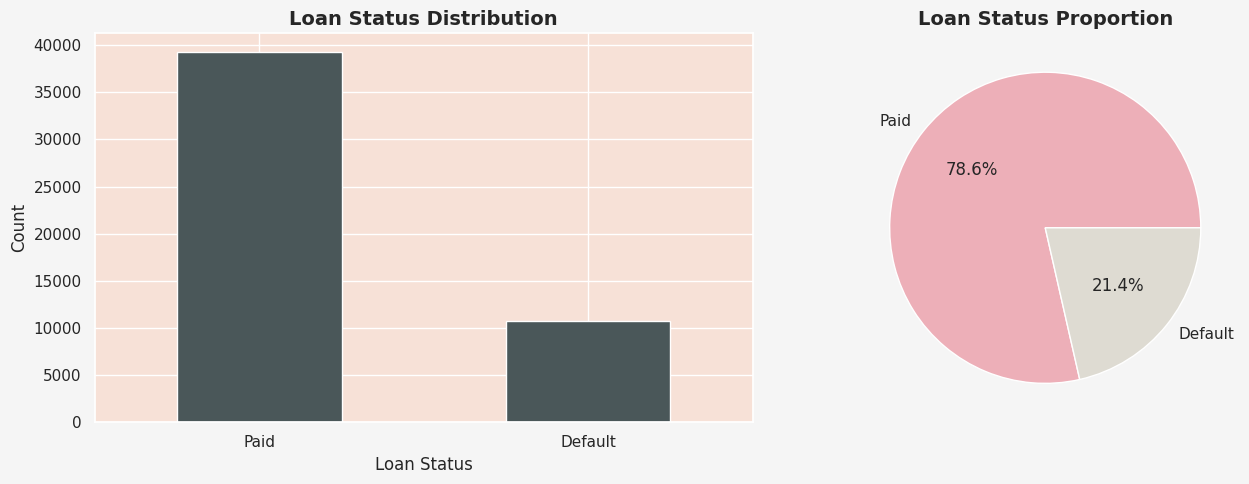


Class Distribution:
  Paid:    39,280 (78.6%)
  Default: 10,720 (21.4%)
  Default Rate: 21.44%


In [6]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
value_counts = df['loan_status_binary'].value_counts().sort_index()
value_counts.plot(kind='bar', ax=axes[0], color= palette[-1] )
axes[0].set_title('Loan Status Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Set tick labels dynamically based on available classes
tick_labels = ['Paid' if i == 0 else 'Default' for i in value_counts.index]
axes[0].set_xticklabels(tick_labels, rotation=0)

# Pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                  colors=palette [:len(value_counts)], 
                  labels=tick_labels)
axes[1].set_title('Loan Status Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(f"  Paid:    {(df['loan_status_binary']==0).sum():,} ({(df['loan_status_binary']==0).mean()*100:.1f}%)")
print(f"  Default: {(df['loan_status_binary']==1).sum():,} ({(df['loan_status_binary']==1).mean()*100:.1f}%)")
print(f"  Default Rate: {df['loan_status_binary'].mean()*100:.2f}%")


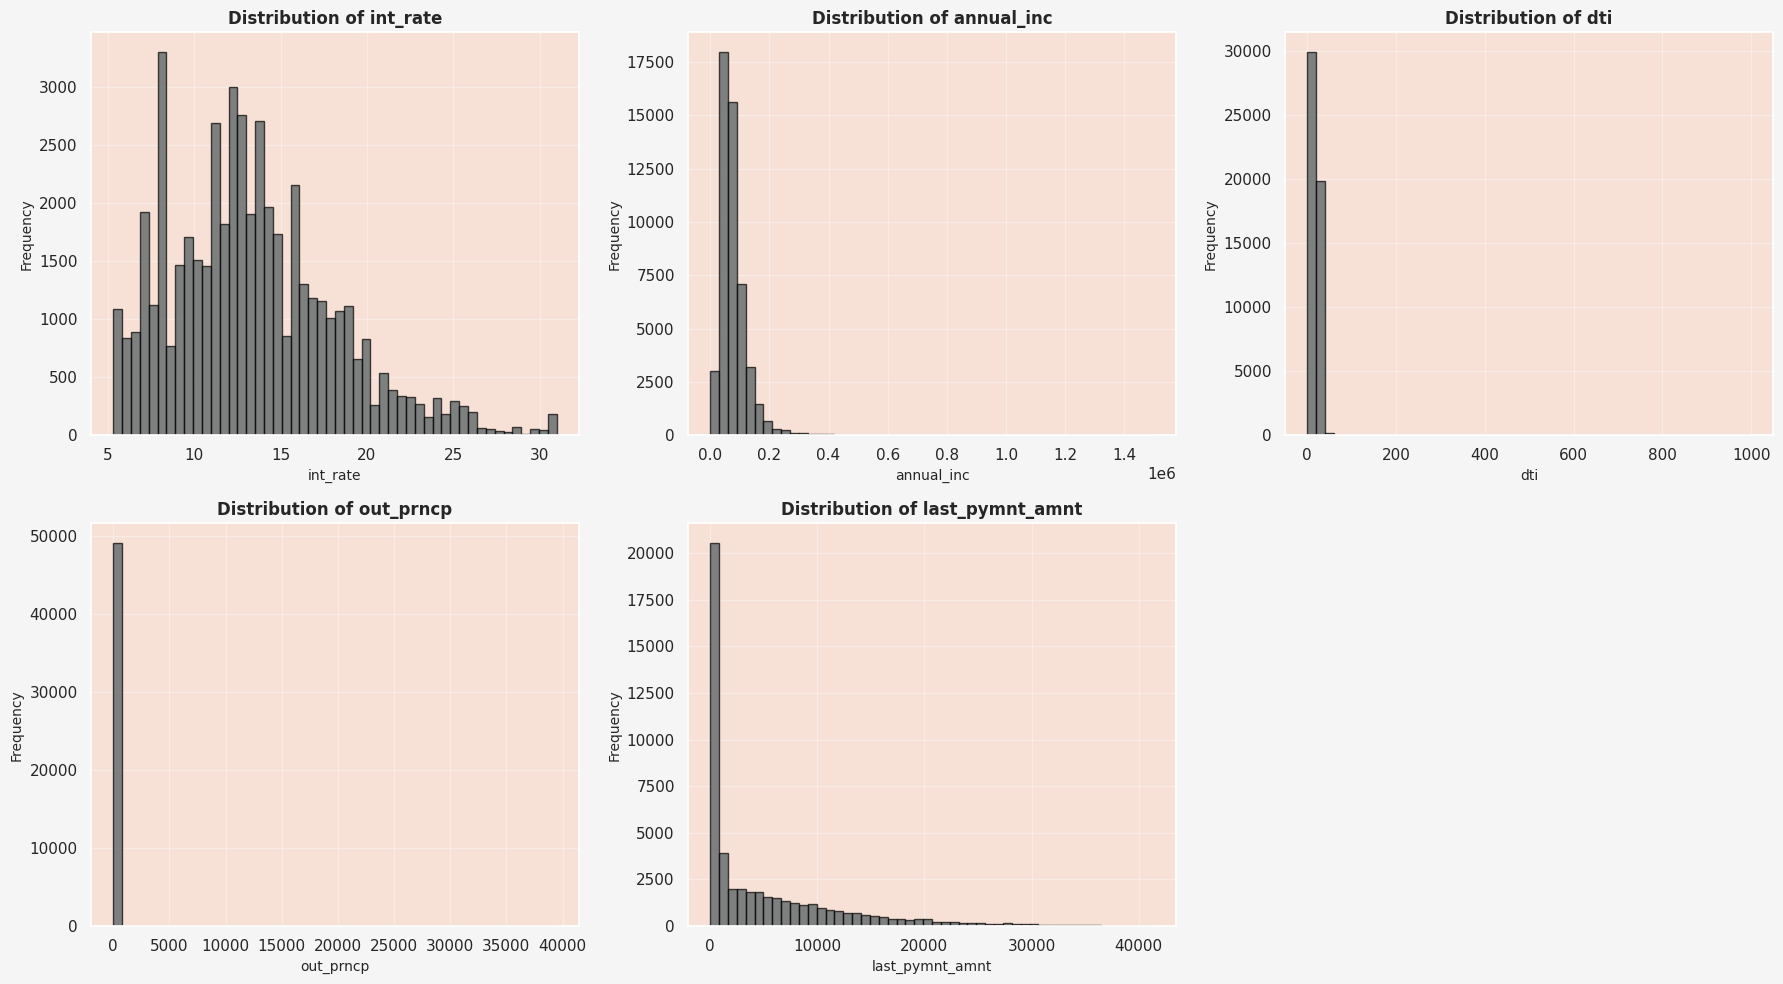

In [7]:
# Distribution of key numerical features

potential_numerical = ['int_rate', 'annual_inc', 'dti', 'fico_score', 'out_prncp', 'last_pymnt_amnt']
numerical_features = [f for f in potential_numerical if f in df.columns]


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        axes[idx].hist(df[col], bins=50, alpha=0.7, color = palette[-1], edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


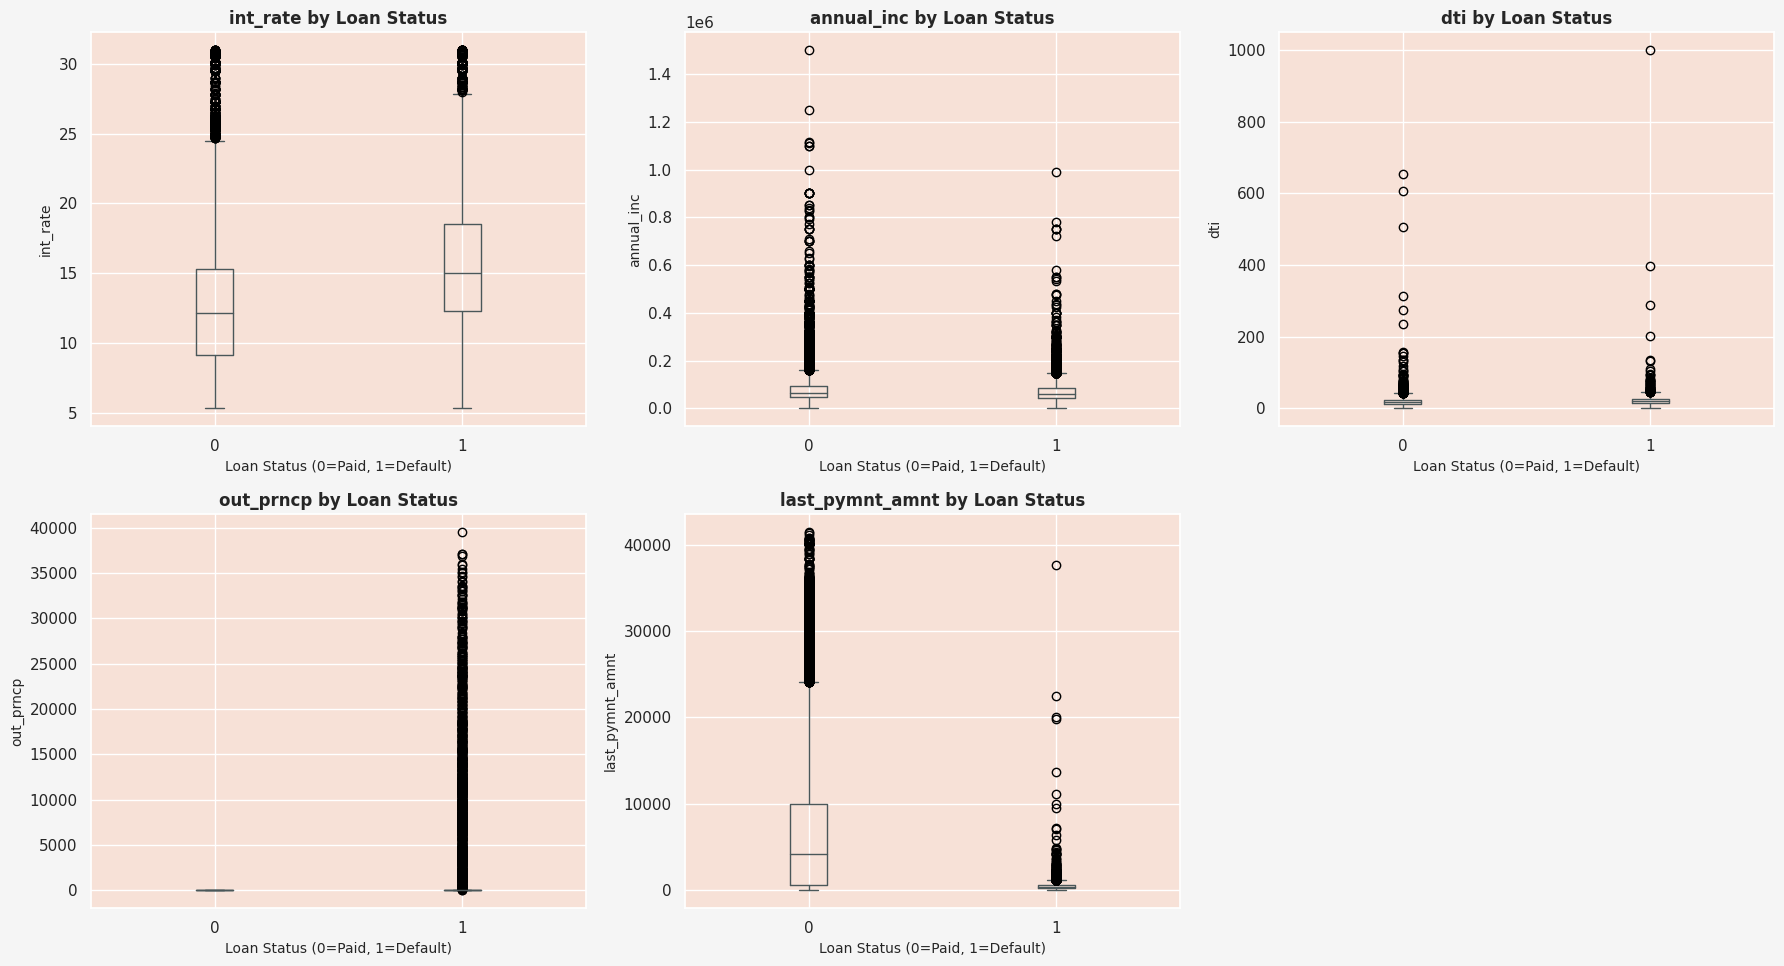

In [8]:
# Feature comparison by loan status
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        df.boxplot(column=col, by='loan_status_binary', ax=axes[idx], color = palette[-1])
        axes[idx].set_title(f'{col} by Loan Status', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Loan Status (0=Paid, 1=Default)', fontsize=10)
        axes[idx].set_ylabel(col, fontsize=10)

# Skip unused Plots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].axis('off')
    
plt.suptitle('')
plt.tight_layout()
plt.show()


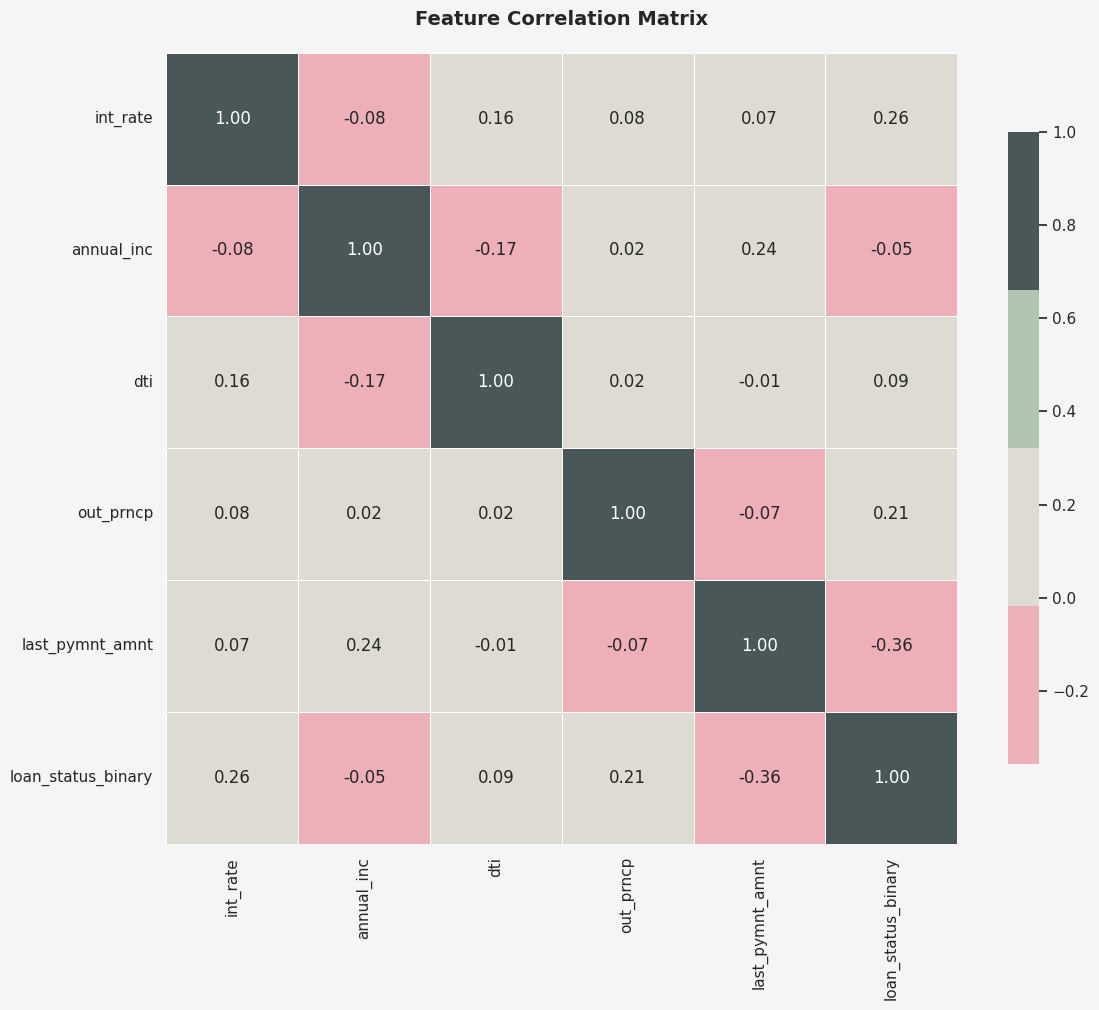

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features + ['loan_status_binary']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f',cmap= cmap, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### Key Observations from EDA:

- **Class imbalance detected**: ~78.6% paid vs ~21.4% default
- **Interest rate** shows clear separation between classes
- **Outstanding principal** and **FICO score** differ significantly by loan status
- **Some features are correlated** - we'll monitor this in SHAP analysis
- This imbalance is realistic but requires careful evaluation


<a id="3"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🔧 3. Data Preprocessing</div>
 

We'll clean the data and prepare features for modeling. This includes handling missing values, converting string columns, and selecting relevant features.

Goal: Transform raw LendingClub data into model-ready features while maintaining data integrity.


In [10]:
# DATA PREPROCESSING & FEATURE ENGINEERING

# STEP 1: CLEANING STRING COLUMNS

# Interest rate: '10.5%' to 0.105
if df['int_rate'].dtype == 'object':
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100

# Revolving utilisation: '85.5%' to 85.5
if 'revol_util' in df.columns and df['revol_util'].dtype == 'object':
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float')

# Employment length: '10+ years' to 10
if 'emp_length' in df.columns and df['emp_length'].dtype == 'object':
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').fillna(0).astype(int)
   

# Loan term: ' 36 months' to 36  
if 'term' in df.columns and df['term'].dtype == 'object':
    df['term'] = df['term'].str.extract('(\d+)').fillna(0).astype(int)

# STEP 2: CREATING UNIFIED FICO SCORE"

# The dataset has multiple FICO columns, let's unify them
fico_cols = [col for col in df.columns if 'fico' in col.lower()]

if fico_cols:    
    # we have a range
    if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
        df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2
    # Otherwise
    elif len(fico_cols) > 0:
        df['fico_score'] = df[fico_cols[0]]      
else:
    # No FICO data, let's handle it
    df['fico_score'] = 700  #(default value = 700 US average)


# STEP 3: FEATURE SELECTION & VALIDATION


# These are the features we'd LIKE to use
desired_features = {
    # Numeric features
    'loan_amnt': 'Loan amount requested','int_rate': 'Interest rate','instalment': 'Monthly payment','annual_inc': 'Annual income',
    'dti': 'Debt-to-income ratio','fico_score': 'FICO credit score','revol_bal': 'Revolving balance','revol_util': 'Revolving utilisation %',
    'out_prncp': 'Outstanding principal','last_pymnt_amnt': 'Last payment amount','tot_cur_bal': 'Total current balance',
    'total_rev_hi_lim': 'Total revolving limit','emp_length': 'Employment length (years)',
    # Categorical features
    'home_ownership': 'Home ownership status','purpose': 'Loan purpose'}

# Let's see what we actually have
available = []
missing = []

for feature, description in desired_features.items():
    if feature in df.columns:
        available.append(feature)
        print(f" {feature:<25} {description}")
    else:
        missing.append(feature)
        print(f" {feature:<25} {description} [NOT FOUND]")

# STEP 4: HANDLING MISSING VALUES

# Check each available feature for nulls
missing_info = df[available].isnull().sum()
features_with_nulls = missing_info[missing_info > 0]

if len(features_with_nulls) > 0:    
    for feature, null_count in features_with_nulls.items():
        null_pct = (null_count / len(df)) * 100
   
    # Numeric features: fill with median 
    numeric_features = df[available].select_dtypes(include=[np.number]).columns
    for col in numeric_features:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        
    
    # Categorical features: fill with mode
    categorical_features = df[available].select_dtypes(include=['object']).columns
    for col in categorical_features:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)

# STEP 5: ENCODING CATEGORICAL VARIABLES

categorical_to_encode = ['home_ownership', 'purpose']
encoded_columns = []

for cat_feature in categorical_to_encode:
    if cat_feature in available:
        # Create a label encoder
        le = LabelEncoder()
        
        # Encode the feature
        encoded_name = f'{cat_feature}_encoded'
        df[encoded_name] = le.fit_transform(df[cat_feature])
        encoded_columns.append(encoded_name)
        
        # Show what we did
        n_categories = len(le.classes_)
        
# STEP 6: FINALIZING FEATURE SET")

# Our final features = numeric features + encoded categorical features
numeric_features = [f for f in available if f not in categorical_to_encode]
final_features = numeric_features + encoded_columns


# STEP 7: TRAIN-TEST SPLIT"

X = df[final_features].copy()
y = df['loan_status_binary'].copy()

# Let's check our target distribution BEFORE splitting
print("\n📊 Target Distribution (Overall):")
for class_val in sorted(y.unique()):
    count = (y == class_val).sum()
    pct = (y == class_val).mean() * 100
    label = "Paid" if class_val == 0 else "Default"
    print(f"   {class_val} ({label:<7}): {count:>8,} samples ({pct:>5.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)


 loan_amnt                 Loan amount requested
 int_rate                  Interest rate
 instalment                Monthly payment [NOT FOUND]
 annual_inc                Annual income
 dti                       Debt-to-income ratio
 fico_score                FICO credit score
 revol_bal                 Revolving balance
 revol_util                Revolving utilisation %
 out_prncp                 Outstanding principal
 last_pymnt_amnt           Last payment amount
 tot_cur_bal               Total current balance
 total_rev_hi_lim          Total revolving limit
 emp_length                Employment length (years)
 home_ownership            Home ownership status
 purpose                   Loan purpose

📊 Target Distribution (Overall):
   0 (Paid   ):   39,280 samples ( 78.6%)
   1 (Default):   10,720 samples ( 21.4%)


<a id="4"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🤖 4. Model Training</div>
  


We'll train three different models: XGBoost, CatBoost, and Random Forest. This allows us to compare how SHAP values differ across model architectures.

Strategy: Train multiple models to see if feature importance patterns are consistent or model-specific.


In [11]:
# Initialize models
models = {
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=0),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

# Train models and store results
results = {}
trained_models = {}
confusion_matrices = {}

print("Training models...")

for name, model in models.items():
    print(f"\n{name}:")
    
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    
    results[name] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1-Score': f1,
        'CV AUC Mean': cv_scores.mean(),
        'CV AUC Std': cv_scores.std()
    }
    
    trained_models[name] = model
    
    # Print Summary
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  AUC:          {auc:.4f}")
    print(f"  F1-Score:     {f1:.4f}")
    print(f"  CV AUC:       {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    print(f"\n  Confusion Matrix: TN={cm[0,0]:,} | FP={cm[0,1]:,} | FN={cm[1,0]:,} | TP={cm[1,1]:,}")
    
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Paid', 'Default']))

print("\nAll models trained successfully.")


Training models...

XGBoost:
  Accuracy:     0.8843
  AUC:          0.9459
  F1-Score:     0.7209
  CV AUC:       0.9448 (±0.0016)

  Confusion Matrix: TN=7,349 | FP=507 | FN=650 | TP=1,494

  Classification Report:
              precision    recall  f1-score   support

        Paid       0.92      0.94      0.93      7856
     Default       0.75      0.70      0.72      2144

    accuracy                           0.88     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.88      0.88      0.88     10000


CatBoost:
  Accuracy:     0.8805
  AUC:          0.9455
  F1-Score:     0.7063
  CV AUC:       0.9429 (±0.0019)

  Confusion Matrix: TN=7,368 | FP=488 | FN=707 | TP=1,437

  Classification Report:
              precision    recall  f1-score   support

        Paid       0.91      0.94      0.92      7856
     Default       0.75      0.67      0.71      2144

    accuracy                           0.88     10000
   macro avg       0.83      0.80      0.

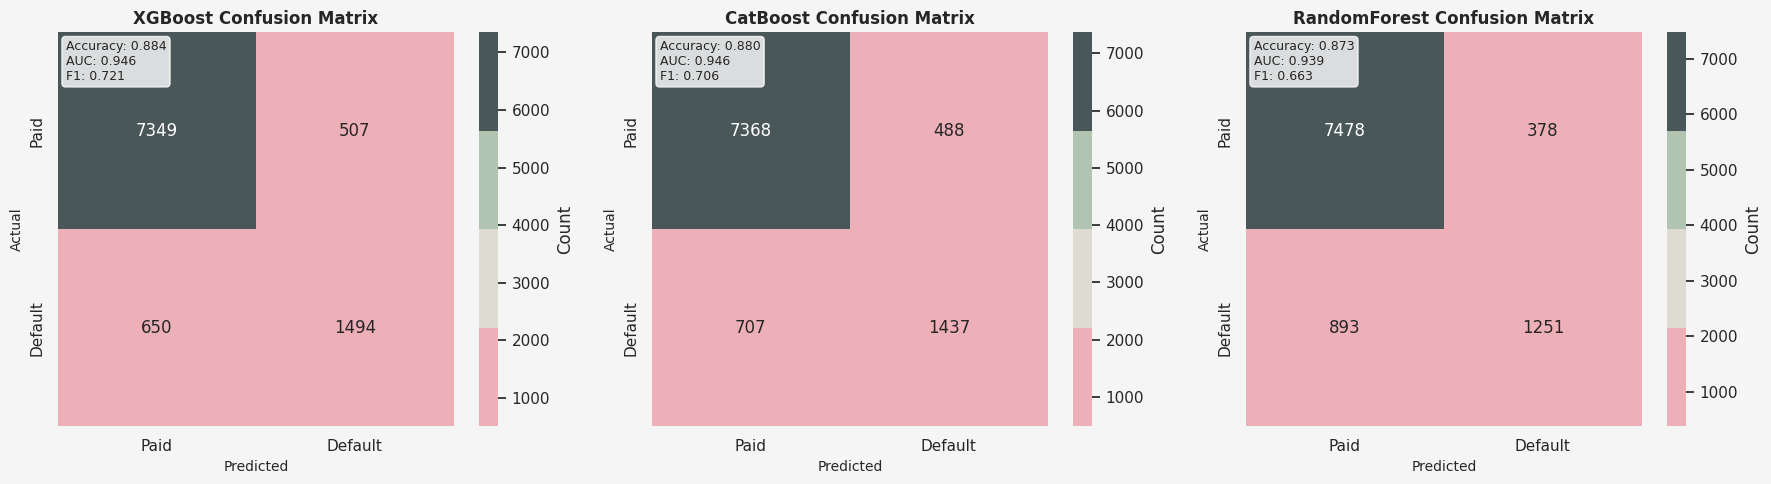

In [12]:
# Visualize Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                cbar_kws={'label': 'Count'},
                xticklabels=['Paid', 'Default'],
                yticklabels=['Paid', 'Default'])
    
    axes[idx].set_title(f'{name} Confusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    
    # Add performance metrics as text
    accuracy = results[name]['Accuracy']
    auc = results[name]['AUC']
    f1 = results[name]['F1-Score']
    
    textstr = f'Accuracy: {accuracy:.3f}\nAUC: {auc:.3f}\nF1: {f1:.3f}'
    axes[idx].text(0.02, 0.98, textstr, transform=axes[idx].transAxes,
                   fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()



Model Performance Comparison:
              Accuracy     AUC  F1-Score  CV AUC Mean  CV AUC Std
XGBoost         0.8843  0.9459    0.7209       0.9448      0.0016
CatBoost        0.8805  0.9455    0.7063       0.9429      0.0019
RandomForest    0.8729  0.9390    0.6631       0.9369      0.0021


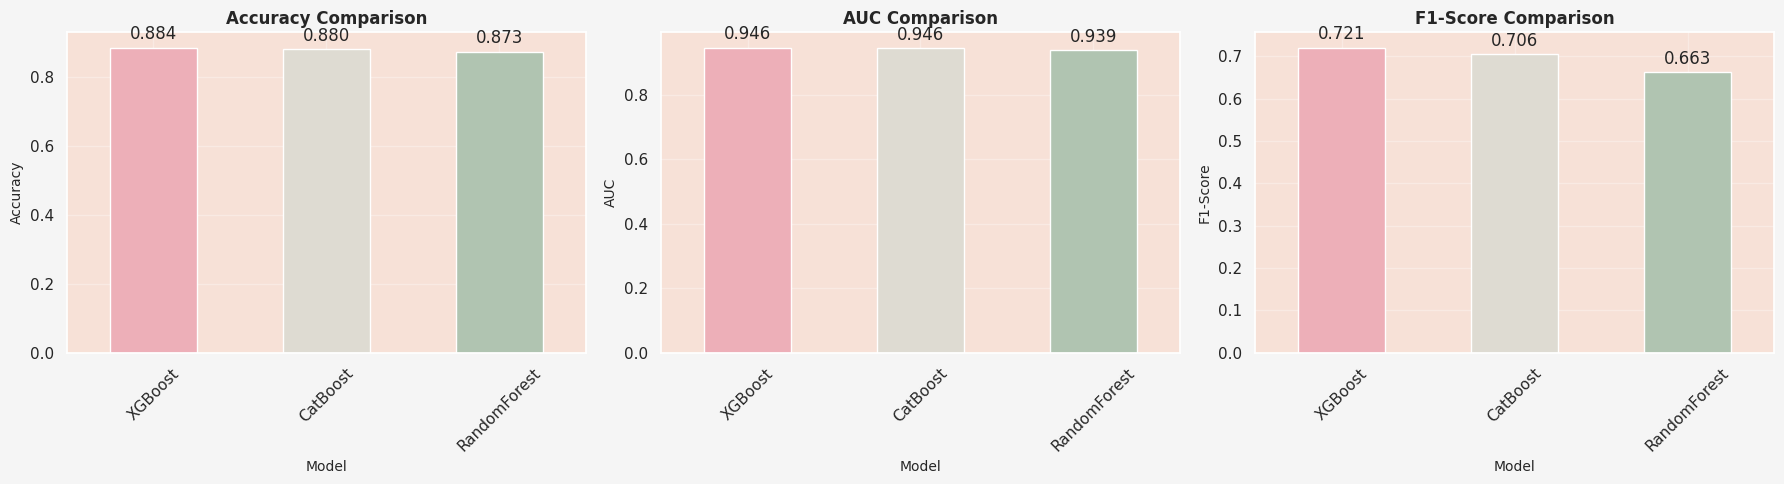

In [13]:
# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.round(4))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'AUC', 'F1-Score']
for idx, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[idx], color= palette)
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=10)
    axes[idx].set_xlabel('Model', fontsize=10)
    axes[idx].set_xticklabels(results_df.index, rotation=45)
    axes[idx].grid(alpha=0.3)
    
    # Add value labels
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()


### Performance Summary

All three models show strong performance on traditional metrics. However, performance metrics alone don't tell us if the models are making decisions based on the right features. 

**Critical Question: Are these models learning genuine risk patterns or over-relying on superficial signals?**

🎯 This is where SHAP analysis becomes crucial.


<a id="5"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🔍 5. SHAP Analysis</div>
 


- Which features drive predictions globally
- Whether any feature dominates unfairly
- If the model relies on biased or unstable patterns

**What is SHAP?** 

SHAP values show how much each feature contributes to individual predictions, based on game theory principles. They provide a mathematically consistent way to understand feature importance.


In [14]:
# Calculate SHAP values for all models
shap_values_dict = {}
explainers_dict = {}

# Use a subset for faster computation
X_test_sample = X_test.iloc[:500]

for name, model in trained_models.items():
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_sample)
    
    # For binary classification, some models return list of arrays
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Take positive class
    
    shap_values_dict[name] = shap_values
    explainers_dict[name] = explainer
    
    print(f"SHAP values computed for {name}")



SHAP values computed for XGBoost
SHAP values computed for CatBoost
SHAP values computed for RandomForest


SHAP Summary Plot: XGBoost


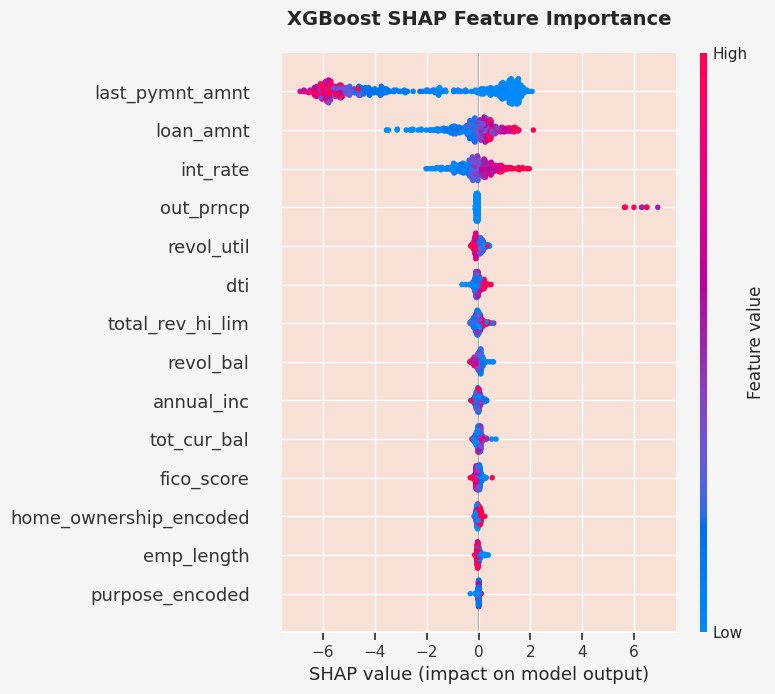

SHAP Summary Plot: CatBoost


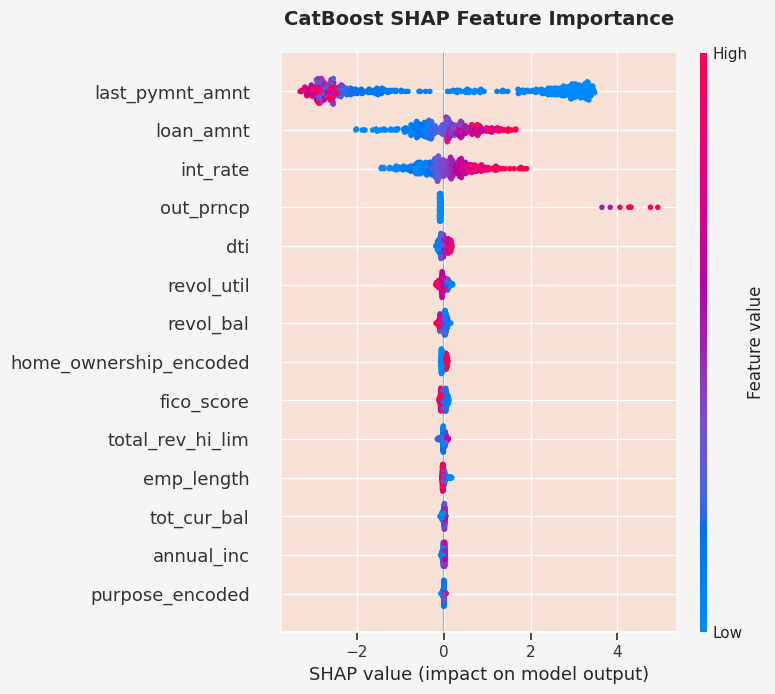

SHAP Summary Plot: RandomForest


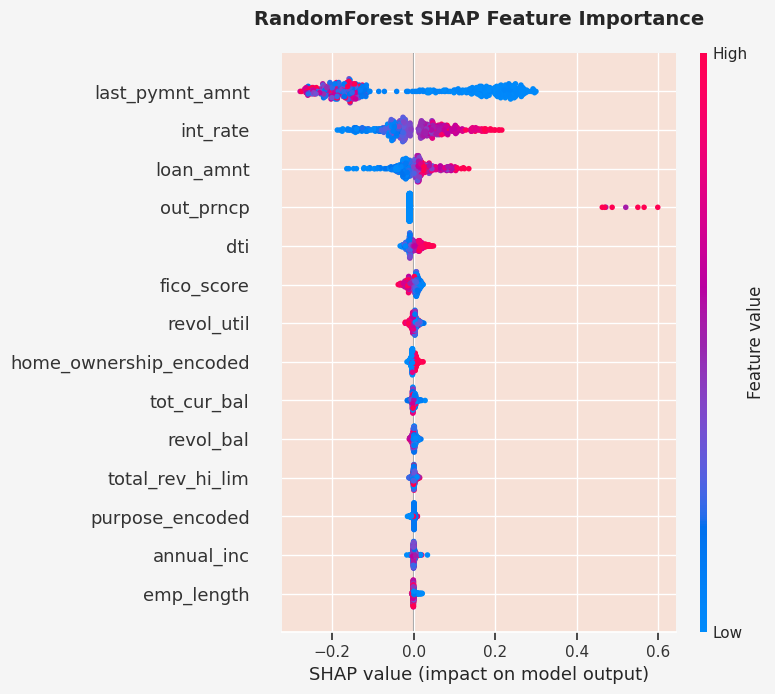

In [15]:
# SHAP Summary Plot for each model
for name in trained_models.keys():
    print(f"SHAP Summary Plot: {name}")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_dict[name], X_test_sample, show=False,color= palette )
    plt.title(f'{name} SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


### Key Insight: Feature Dominance Detected

From the SHAP summary plots above, notice:

- `last_pymnt_amnt` (last payment amount) dominates predictions significantly
- This feature overshadows all other indicators including `int_rate`, `loan_amnt`, and `fico_score`
- **Critical Issue**: `last_pymnt_amnt` is a post-outcome feature that represents payments made after we need to make our prediction
- This is data leakage; the model is using future information to predict the past

This is exactly the concern: High metrics can mask fundamental flaws. Our 94.6% AUC looks perfect, but SHAP reveals the model learned nothing about genuine credit risk.

Next: Let's quantify this dominance with bar plots.


SHAP Bar Plot: XGBoost


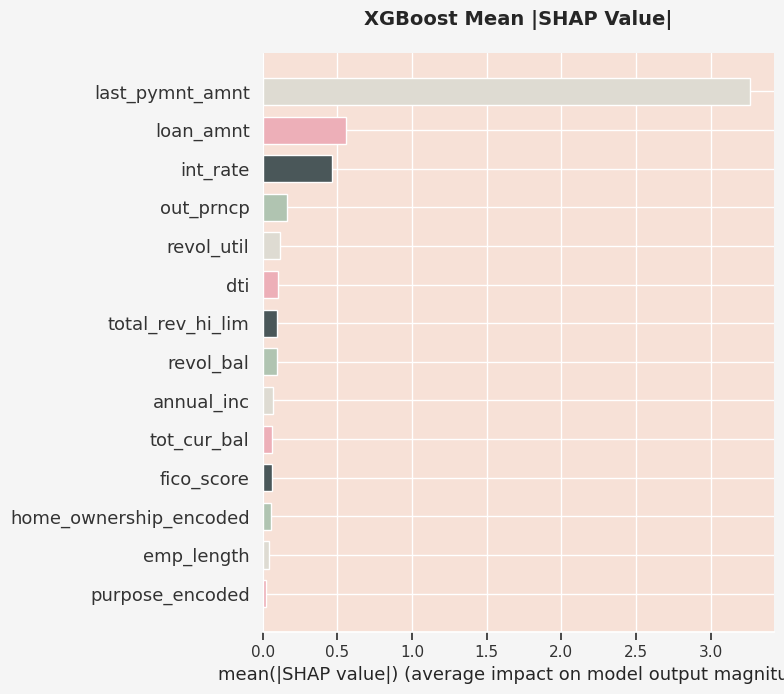

SHAP Bar Plot: CatBoost


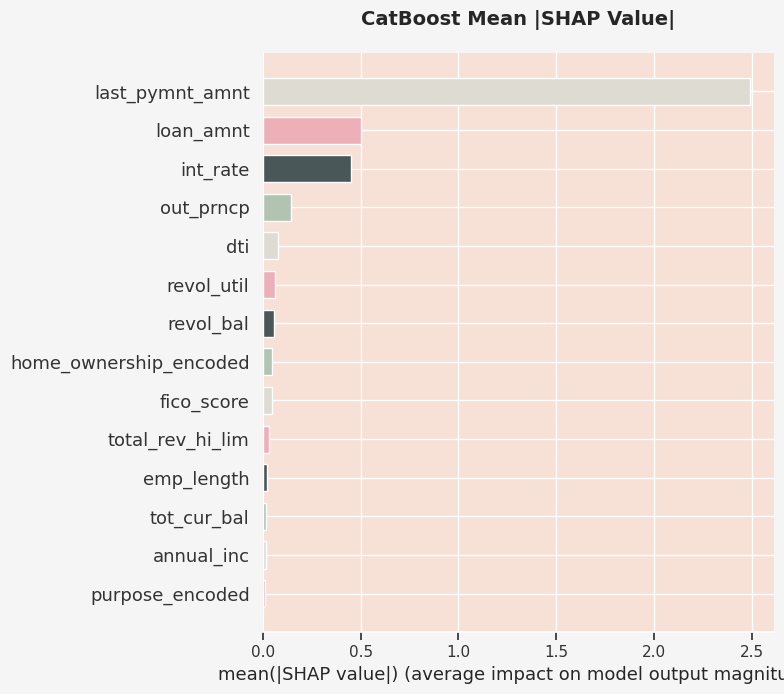

SHAP Bar Plot: RandomForest


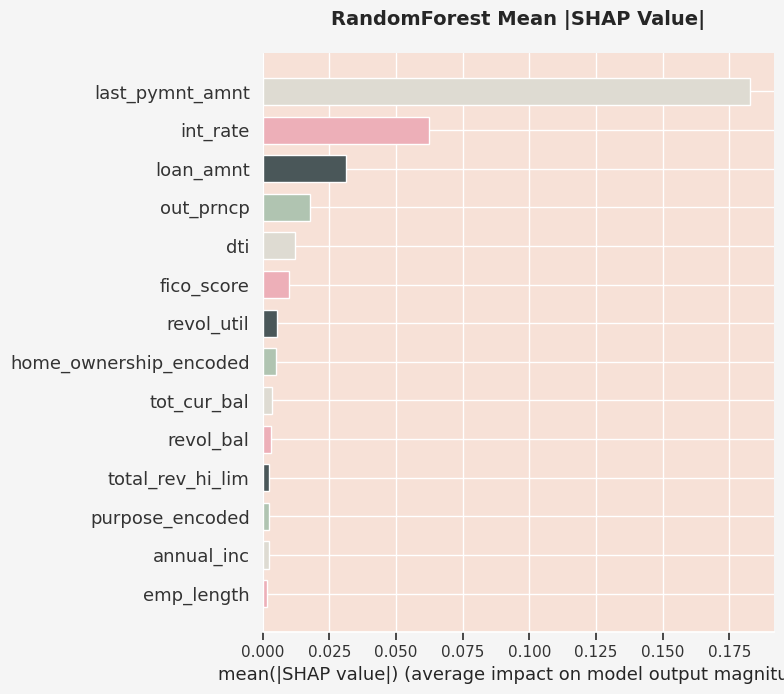

In [16]:
# SHAP Bar Plot - Mean absolute SHAP values
for name in trained_models.keys():
    print(f"SHAP Bar Plot: {name}")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_dict[name], X_test_sample, plot_type='bar', show=False, color = palette)
    plt.title(f'{name} Mean |SHAP Value|', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


In [17]:
# Compare top 5 features across models
top_features_comparison = {}

for name in trained_models.keys():
    mean_abs_shap = np.abs(shap_values_dict[name]).mean(axis=0)
    feature_importance = pd.DataFrame({ 'feature': final_features,'importance': mean_abs_shap }).sort_values('importance', ascending=False)
    
    top_features_comparison[name] = feature_importance.head(5)

# Display comparison
print("\nTop 5 Features by SHAP Importance:\n")
for name, features in top_features_comparison.items():
    print(f"\n{name}:")
    print(features.to_string(index=False))


Top 5 Features by SHAP Importance:


XGBoost:
        feature  importance
last_pymnt_amnt    3.261002
      loan_amnt    0.554742
       int_rate    0.465305
      out_prncp    0.159537
     revol_util    0.115279

CatBoost:
        feature  importance
last_pymnt_amnt    2.488923
      loan_amnt    0.503448
       int_rate    0.450116
      out_prncp    0.144627
            dti    0.076968

RandomForest:
        feature  importance
last_pymnt_amnt    0.182648
       int_rate    0.062395
      loan_amnt    0.031105
      out_prncp    0.017769
            dti    0.012148


In [18]:
# Compare top 5 features across models
top_features_comparison = {}

for name in trained_models.keys():
    mean_abs_shap = np.abs(shap_values_dict[name]).mean(axis=0)
    feature_importance = pd.DataFrame({'feature': final_features,'importance': mean_abs_shap}).sort_values('importance', ascending=False)
    
    top_features_comparison[name] = feature_importance.head(5)

# Display comparison
print("\nTop 5 Features by SHAP Importance:\n")
for name, features in top_features_comparison.items():
    print(f"\n{name}:")
    print(features.to_string(index=False))




Top 5 Features by SHAP Importance:


XGBoost:
        feature  importance
last_pymnt_amnt    3.261002
      loan_amnt    0.554742
       int_rate    0.465305
      out_prncp    0.159537
     revol_util    0.115279

CatBoost:
        feature  importance
last_pymnt_amnt    2.488923
      loan_amnt    0.503448
       int_rate    0.450116
      out_prncp    0.144627
            dti    0.076968

RandomForest:
        feature  importance
last_pymnt_amnt    0.182648
       int_rate    0.062395
      loan_amnt    0.031105
      out_prncp    0.017769
            dti    0.012148


FEATURE DOMINANCE ANALYSIS

📊 Feature Dominance Breakdown (XGBoost):

         Feature  SHAP_Importance  Percentage
 last_pymnt_amnt         3.261002   63.254398
       loan_amnt         0.554742   10.760459
        int_rate         0.465305    9.025625
       out_prncp         0.159537    3.094573
      revol_util         0.115279    2.236096
             dti         0.099173    1.923679
total_rev_hi_lim         0.094400    1.831095
       revol_bal         0.093770    1.818885
      annual_inc         0.067829    1.315701
     tot_cur_bal         0.063825    1.238035


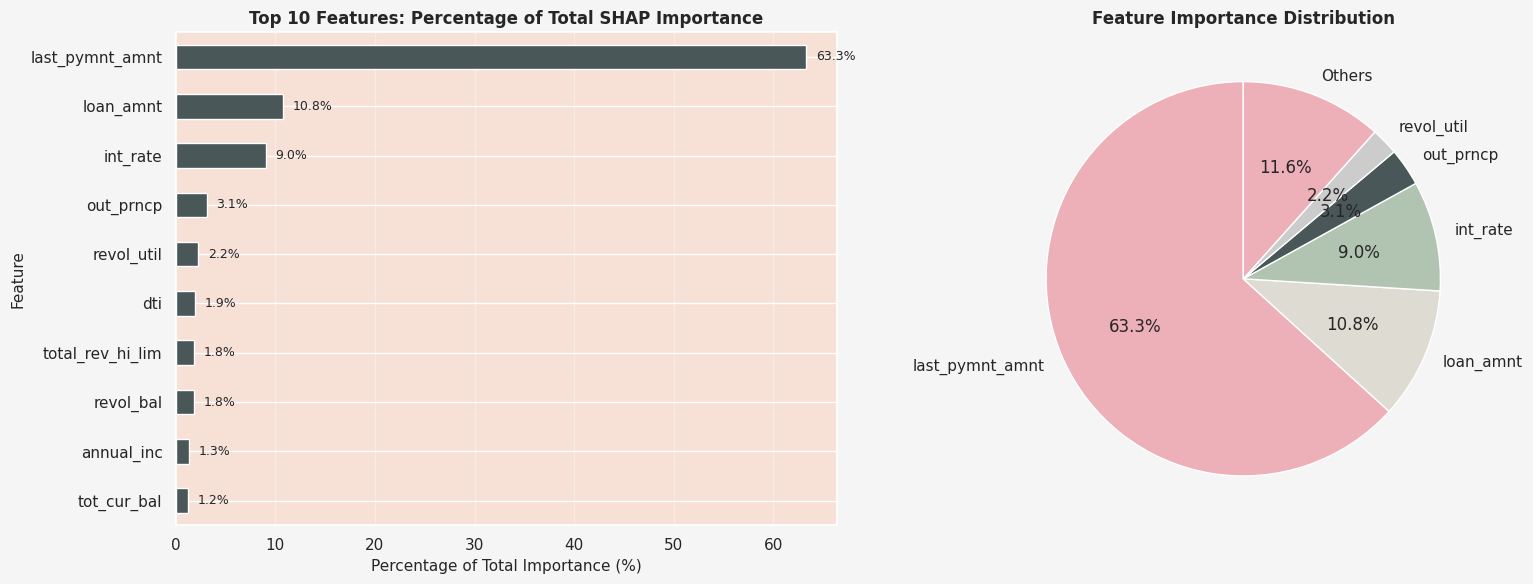

DOMINANCE ASSESSMENT

🔍 Top Feature: last_pymnt_amnt
   Importance: 63.25% of total
   Gap to #2: 52.49 percentage points

🚨 CRITICAL: 'last_pymnt_amnt' accounts for 63.3% of total importance!
   This extreme dominance suggests:
   • Potential data leakage
   • Model over-reliance on single feature
   • High fragility risk

📈 Gini Coefficient: -0.727
   (0 = perfect equality, 1 = maximum inequality)
   ✅ Low inequality - relatively balanced feature usage


In [19]:
print("FEATURE DOMINANCE ANALYSIS")

# Analyze feature dominance for XGBoost (our best model)
mean_abs_shap_xgb = np.abs(shap_values_dict['XGBoost']).mean(axis=0)
total_shap = mean_abs_shap_xgb.sum()

dominance_df = pd.DataFrame({
    'Feature': final_features,
    'SHAP_Importance': mean_abs_shap_xgb,
    'Percentage': (mean_abs_shap_xgb / total_shap) * 100
}).sort_values('SHAP_Importance', ascending=False)

print("\n📊 Feature Dominance Breakdown (XGBoost):\n")
print(dominance_df.head(10).to_string(index=False))

# Visualize dominance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
dominance_df.head(10).plot(kind='barh', x='Feature', y='Percentage', 
                            ax=axes[0], color=palette[3], legend=False)
axes[0].set_title('Top 10 Features: Percentage of Total SHAP Importance', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Percentage of Total Importance (%)', fontsize=11)
axes[0].set_ylabel('Feature', fontsize=11)
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Add percentage labels
for idx, (feature, percentage) in enumerate(zip(dominance_df.head(10)['Feature'], 
                                                  dominance_df.head(10)['Percentage'])):
    axes[0].text(percentage + 1, idx, f'{percentage:.1f}%', 
                va='center', fontsize=9)

# Pie chart for top 5 + others
top_5 = dominance_df.head(5)
others_pct = dominance_df.iloc[5:]['Percentage'].sum()
pie_data = list(top_5['Percentage']) + [others_pct]
pie_labels = list(top_5['Feature']) + ['Others']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
            colors=palette + ['#cccccc'], startangle=90)
axes[1].set_title('Feature Importance Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Flag dominance issues

print("DOMINANCE ASSESSMENT")

top_feature = dominance_df.iloc[0]
top_feature_pct = top_feature['Percentage']
second_feature_pct = dominance_df.iloc[1]['Percentage']

print(f"\n🔍 Top Feature: {top_feature['Feature']}")
print(f"   Importance: {top_feature_pct:.2f}% of total")
print(f"   Gap to #2: {top_feature_pct - second_feature_pct:.2f} percentage points")

if top_feature_pct > 60:
    print(f"\n🚨 CRITICAL: '{top_feature['Feature']}' accounts for {top_feature_pct:.1f}% of total importance!")
    print("   This extreme dominance suggests:")
    print("   • Potential data leakage")
    print("   • Model over-reliance on single feature")
    print("   • High fragility risk")
elif top_feature_pct > 40:
    print(f"\n WARNING: '{top_feature['Feature']}' accounts for {top_feature_pct:.1f}% of total importance")
    print("   This suggests significant feature dominance - investigate further")
else:
    print(f"\n✅ Feature distribution is relatively balanced")
    print(f"   Top feature: {top_feature_pct:.1f}% (under 40% threshold)")

# Calculate Gini coefficient for feature importance distribution
def gini_coefficient(x):
    """CalculateS Gini coefficient for inequality measurement"""
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(1, n + 1) + 1) * sorted_x)) / (n * np.sum(sorted_x)) - (n + 1) / n

gini = gini_coefficient(dominance_df['SHAP_Importance'].values)
print(f"\n📈 Gini Coefficient: {gini:.3f}")
print(f"   (0 = perfect equality, 1 = maximum inequality)")

if gini > 0.7:
    print("   🚨 High inequality - feature importance very concentrated")
elif gini > 0.5:
    print("   ⚠️  Moderate inequality - some features dominate")
else:
    print("   ✅ Low inequality - relatively balanced feature usage")


<a id="6"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">📈 6. SHAP Dependence Plots</div>
 

Dependence plots show how a feature's SHAP value (its impact on prediction) changes with its actual value. 

**What to Look For:**
- Smooth, consistent curves = stable feature behavior
- Noisy, irregular curves = unstable behavior in certain regions
- Unexpected patterns = potential data quality issues

Let's examine the top features from our SHAP analysis:


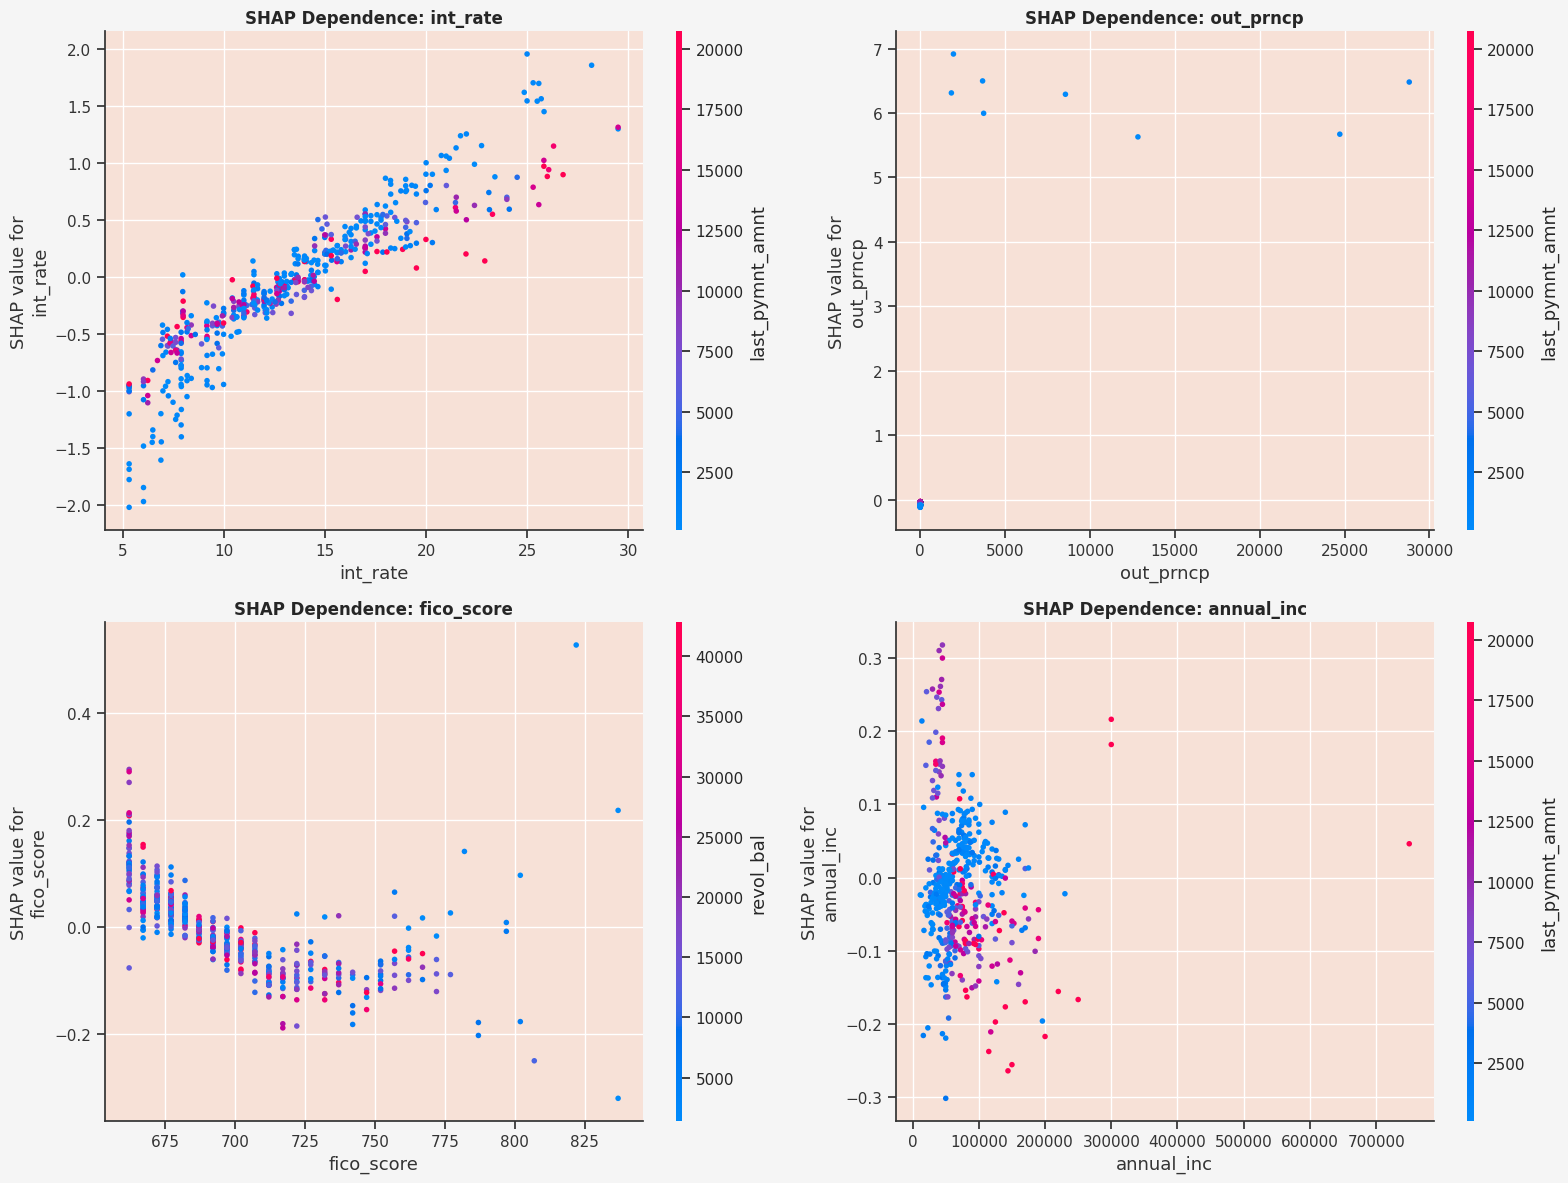

In [20]:
# SHAP Dependence Plots for top features (using XGBoost as example)
model_name = 'XGBoost'
top_features = ['int_rate', 'out_prncp', 'fico_score', 'annual_inc']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    shap.dependence_plot(feature, shap_values_dict[model_name], X_test_sample, 
                         ax=axes[idx], show=False)
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


<a id="7"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">⚠️ 7. Data Leakage Detection</div>


<div style="background-color: #f7e1d7; padding: 20px; border-radius: 10px; border-left: 5px solid #4a5759; margin: 20px 0;">
<strong>🚨 Critical Discovery:</strong> Our SHAP analysis revealed that <code>last_pymnt_amnt</code> dominates predictions. This is a classic case of <strong>data leakage</strong> - using post outcome information to predict past decisions.
</div>

**What is Data Leakage?**

Data leakage occurs when information from outside the training dataset is used to create the model. In credit risk:
- **Valid features**: Information available at loan application (income, FICO score, loan amount)
- **Leakage features**: Information known only after loan outcome (payment history, outstanding principal)

**Why It Matters:**

Our model achieved 94.6% AUC, but it's essentially cheating by looking at payment behaviour that happens after the loan decision. In production, these features won't exist yet!

Let's identify and remove leakage features, then build a "clean" model representing true predictive power.


DATA LEAKAGE DETECTION

🔍 Analyzing features for data leakage...

 LEAKAGE: out_prncp
 LEAKAGE: last_pymnt_amnt

📊 Analysis Summary:
  Total features: 14
  Clean features: 12
  Leakage features: 2

 Clean features (available at application time):
  • loan_amnt
  • int_rate
  • annual_inc
  • dti
  • fico_score
  • revol_bal
  • revol_util
  • tot_cur_bal
  • total_rev_hi_lim
  • emp_length
  • home_ownership_encoded
  • purpose_encoded
TRAINING CLEAN MODEL (NO DATA LEAKAGE)

 Clean dataset shape:
  Training: (40000, 12)
  Testing: (10000, 12)

🔧 Training XGBoost with clean features only...

✅ Clean Model Performance:
  Accuracy: 0.7849
  AUC: 0.6950
  F1-Score: 0.1441
  CV AUC: 0.6968 (±0.0045)
LEAKAGE IMPACT ASSESSMENT

  Metric  With Leakage  Clean Model     Drop    Drop %
Accuracy      0.884300     0.784900 0.099400 11.240529
     AUC      0.945897     0.695005 0.250892 26.524271
F1-Score      0.720869     0.144051 0.576818 80.017031


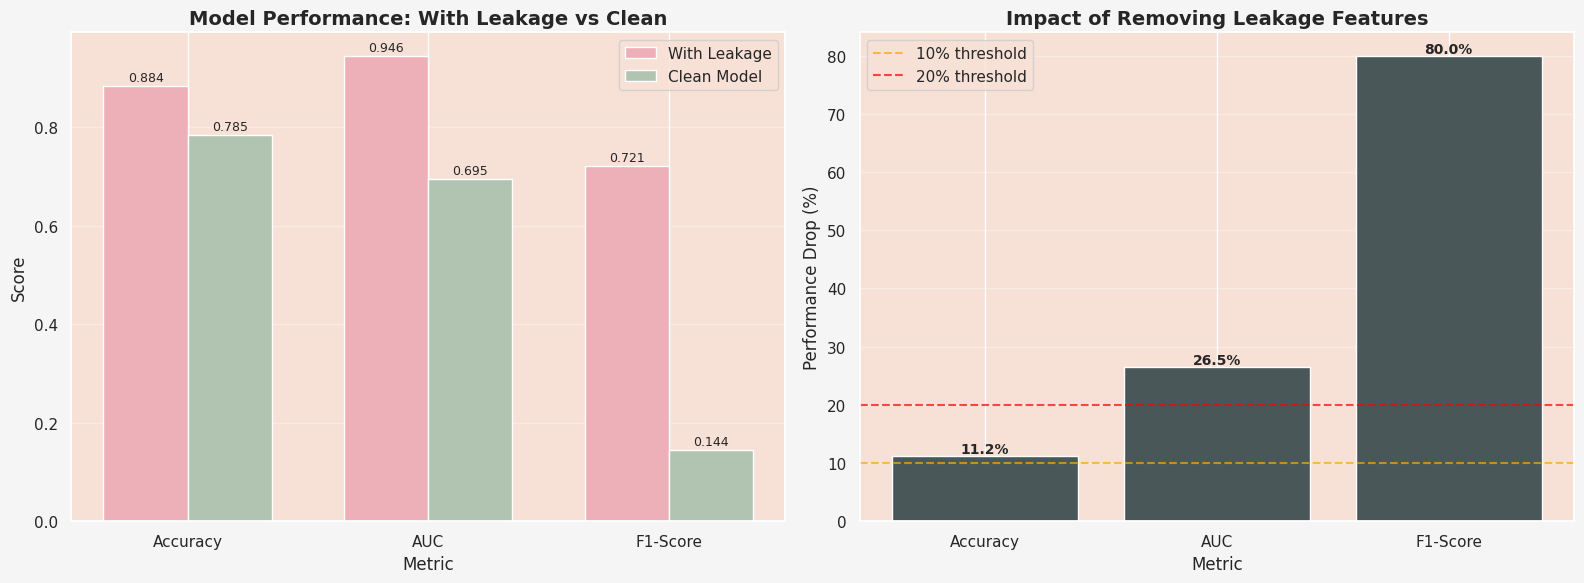

ASSESSMENT

💡 Key Findings:
  • Original AUC (with leakage): 0.9459
  • Clean AUC (no leakage): 0.6950
  • Performance drop: 26.52%

 SEVERE LEAKAGE IMPACT: 26.5% AUC drop
  The original model was heavily dependent on post-outcome information!
  Clean model represents TRUE predictive power at application time.

📌 Conclusion:
  The clean model's 0.6950 AUC represents what we can ACTUALLY
  expect in production when making real loan decisions.


In [21]:

print("DATA LEAKAGE DETECTION")

# Features that shouldn't be available at loan application time
leakage_keywords = [
    'pymnt', 'prncp', 'rec_', 'collection', 'recovery', 
    'last_', 'total_pymnt', 'out_prncp', 'next_pymnt'
]

# Identify leakage features
leakage_features = []
clean_features = []

print("\n🔍 Analyzing features for data leakage...\n")

for feature in final_features:
    is_leakage = any(keyword in feature.lower() for keyword in leakage_keywords)
    
    if is_leakage:
        leakage_features.append(feature)
        print(f" LEAKAGE: {feature}")
    else:
        clean_features.append(feature)

print(f"\n📊 Analysis Summary:")
print(f"  Total features: {len(final_features)}")
print(f"  Clean features: {len(clean_features)}")
print(f"  Leakage features: {len(leakage_features)}")
print(f"\n Clean features (available at application time):")
for feat in clean_features:
    print(f"  • {feat}")

# TRAIN CLEAN MODEL (NO LEAKAGE)

print("TRAINING CLEAN MODEL (NO DATA LEAKAGE)")

X_train_clean = X_train[clean_features]
X_test_clean = X_test[clean_features]

print(f"\n Clean dataset shape:")
print(f"  Training: {X_train_clean.shape}")
print(f"  Testing: {X_test_clean.shape}")

# Train XGBoost on clean features
print(f"\n🔧 Training XGBoost with clean features only...")
model_clean = XGBClassifier( n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')
model_clean.fit(X_train_clean, y_train)

# Evaluate clean model
y_pred_clean = model_clean.predict(X_test_clean)
y_pred_proba_clean = model_clean.predict_proba(X_test_clean)[:, 1]

accuracy_clean = accuracy_score(y_test, y_pred_clean)
auc_clean = roc_auc_score(y_test, y_pred_proba_clean)
f1_clean = f1_score(y_test, y_pred_clean)

# Cross-validation
cv_scores_clean = cross_val_score(model_clean, X_train_clean, y_train, cv=5, scoring='roc_auc')

print(f"\n✅ Clean Model Performance:")
print(f"  Accuracy: {accuracy_clean:.4f}")
print(f"  AUC: {auc_clean:.4f}")
print(f"  F1-Score: {f1_clean:.4f}")
print(f"  CV AUC: {cv_scores_clean.mean():.4f} (±{cv_scores_clean.std():.4f})")

# Compare with original model
print("LEAKAGE IMPACT ASSESSMENT")

original_results = results['XGBoost']

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC', 'F1-Score'],
    'With Leakage': [original_results['Accuracy'], original_results['AUC'], original_results['F1-Score']],
    'Clean Model': [accuracy_clean, auc_clean, f1_clean],
    'Drop': [
        original_results['Accuracy'] - accuracy_clean,
        original_results['AUC'] - auc_clean,
        original_results['F1-Score'] - f1_clean
    ],
    'Drop %': [
        ((original_results['Accuracy'] - accuracy_clean) / original_results['Accuracy'] * 100),
        ((original_results['AUC'] - auc_clean) / original_results['AUC'] * 100),
        ((original_results['F1-Score'] - f1_clean) / original_results['F1-Score'] * 100)
    ]
})

print(f"\n{comparison_df.to_string(index=False)}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar comparison
x = np.arange(len(comparison_df['Metric']))
width = 0.35

axes[0].bar(x - width/2, comparison_df['With Leakage'], width, 
           label='With Leakage', color=palette[0])
axes[0].bar(x + width/2, comparison_df['Clean Model'], width, 
           label='Clean Model', color=palette[2])

axes[0].set_xlabel('Metric', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance: With Leakage vs Clean', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Metric'])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Add value labels
for i, (leak, clean) in enumerate(zip(comparison_df['With Leakage'], comparison_df['Clean Model'])):
    axes[0].text(i - width/2, leak + 0.01, f'{leak:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, clean + 0.01, f'{clean:.3f}', ha='center', fontsize=9)

# Performance drop visualization
axes[1].bar(comparison_df['Metric'], comparison_df['Drop %'], color=palette[3])
axes[1].set_xlabel('Metric', fontsize=12)
axes[1].set_ylabel('Performance Drop (%)', fontsize=12)
axes[1].set_title('Impact of Removing Leakage Features', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
axes[1].axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='10% threshold')
axes[1].axhline(y=20, color='red', linestyle='--', alpha=0.7, label='20% threshold')
axes[1].legend()

# Add value labels
for i, (metric, drop) in enumerate(zip(comparison_df['Metric'], comparison_df['Drop %'])):
    axes[1].text(i, drop + 0.5, f'{drop:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Assessment
auc_drop_pct = ((original_results['AUC'] - auc_clean) / original_results['AUC'] * 100)

print("ASSESSMENT")

print(f"\n💡 Key Findings:")
print(f"  • Original AUC (with leakage): {original_results['AUC']:.4f}")
print(f"  • Clean AUC (no leakage): {auc_clean:.4f}")
print(f"  • Performance drop: {auc_drop_pct:.2f}%")

if auc_drop_pct > 20:
    print(f"\n SEVERE LEAKAGE IMPACT: {auc_drop_pct:.1f}% AUC drop")
    print("  The original model was heavily dependent on post-outcome information!")
    print("  Clean model represents TRUE predictive power at application time.")
elif auc_drop_pct > 10:
    print(f"\n SIGNIFICANT LEAKAGE: {auc_drop_pct:.1f}% AUC drop")
    print("  Leakage features inflated performance considerably.")
else:
    print(f"\n MINIMAL LEAKAGE: {auc_drop_pct:.1f}% AUC drop")
    print("  Model performance is relatively authentic.")

print(f"\n📌 Conclusion:")
print(f"  The clean model's {auc_clean:.4f} AUC represents what we can ACTUALLY")
print(f"  expect in production when making real loan decisions.")


### Interpretation of Dependence Plots:

- **Interest Rate**: Shows clear positive relationship - higher rates increase default probability
- **Outstanding Principal**: Similar positive trend, but may show some noise
- **FICO Score**: Negative relationship (higher score = lower default risk) - as expected
- **Annual Income**: May show weaker or noisier patterns, suggesting it's underutilized

**Key Takeaway**: Noisy dependence plots indicate the model might be reacting inconsistently to those features in different contexts. This is a red flag for model reliability.


<a id="8"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🧪 8. Fragility Testing</div>
 
**The Critical Question: What happens if we remove the top SHAP feature?**

**Why This Matters:**
- A steep accuracy drop = over-reliance on that feature
- A small drop = model has learned robust patterns
- This test reveals whether the model is truly understanding risk or just memorising shortcuts

**Hypothesis**: If the model drops >10% in AUC, it's too fragile and over-dependent on a single feature.


In [22]:
# Identify top feature for XGBoost
mean_abs_shap_xgb = np.abs(shap_values_dict['XGBoost']).mean(axis=0)
top_feature_idx = np.argmax(mean_abs_shap_xgb)
top_feature_name = final_features[top_feature_idx]

print(f"Top SHAP feature for XGBoost: {top_feature_name}")
print(f"Mean |SHAP value|: {mean_abs_shap_xgb[top_feature_idx]:.4f}")


Top SHAP feature for XGBoost: last_pymnt_amnt
Mean |SHAP value|: 3.2610


In [23]:
# Train model without top feature
features_without_top = [f for f in final_features if f != top_feature_name]

X_train_reduced = X_train[features_without_top]
X_test_reduced = X_test[features_without_top]

# Train new model
print(f"\nTraining XGBoost WITHOUT '{top_feature_name}'...\n")
model_reduced = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')
model_reduced.fit(X_train_reduced, y_train)

# Evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
y_pred_proba_reduced = model_reduced.predict_proba(X_test_reduced)[:, 1]

accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
auc_reduced = roc_auc_score(y_test, y_pred_proba_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced)

# Compare
print("\nFragility Test Results:")
print(f"{'Metric':<20} {'Original':<15} {'Without Top Feature':<20} {'Drop':<10}")
 

original_results = results['XGBoost']
print(f"{'Accuracy':<20} {original_results['Accuracy']:<15.4f} {accuracy_reduced:<20.4f} {(original_results['Accuracy'] - accuracy_reduced):<10.4f}")
print(f"{'AUC':<20} {original_results['AUC']:<15.4f} {auc_reduced:<20.4f} {(original_results['AUC'] - auc_reduced):<10.4f}")
print(f"{'F1-Score':<20} {original_results['F1-Score']:<15.4f} {f1_reduced:<20.4f} {(original_results['F1-Score'] - f1_reduced):<10.4f}")
 

# Interpretation
auc_drop_pct = (original_results['AUC'] - auc_reduced) / original_results['AUC'] * 100
print(f"\nAUC dropped by {auc_drop_pct:.2f}% when removing '{top_feature_name}'")

if auc_drop_pct > 10:
    print(f"WARNING: Significant performance drop indicates OVER-RELIANCE on '{top_feature_name}'")
elif auc_drop_pct > 5:
    print(f"CAUTION: Moderate dependence on '{top_feature_name}' detected")
else:
    print(f"Model shows resilience - balanced feature contribution")


Training XGBoost WITHOUT 'last_pymnt_amnt'...


Fragility Test Results:
Metric               Original        Without Top Feature  Drop      
Accuracy             0.8843          0.8045               0.0798    
AUC                  0.9459          0.7261               0.2198    
F1-Score             0.7209          0.2360               0.4848    

AUC dropped by 23.24% when removing 'last_pymnt_amnt'


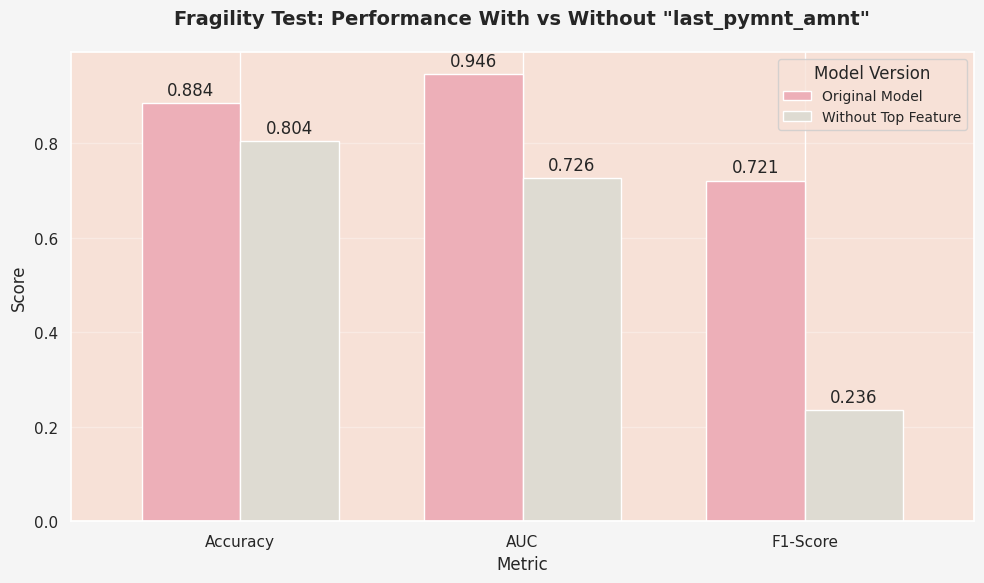


Fragility Test Analysis:
  The model's 94.6% AUC collapsed to 72.6% when we removed last_pymnt_amnt
  F1-Score dropped from 0.72 to 0.24 (67% decrease)

Interpretation:
  The model learned nothing about genuine credit risk
  It simply memorized: 'low last payment = default'
  Performance metrics alone would not catch this

Conclusion: This validates that accuracy without understanding is dangerous


In [24]:
# Visualize fragility test results
comparison_data = pd.DataFrame({
    'Original Model': [original_results['Accuracy'], original_results['AUC'], original_results['F1-Score']],
    'Without Top Feature': [accuracy_reduced, auc_reduced, f1_reduced]}, index=['Accuracy', 'AUC', 'F1-Score'])

ax = comparison_data.plot(kind='bar', figsize=(10, 6), color=palette, width=0.7)
plt.title(f'Fragility Test: Performance With vs Without "{top_feature_name}"', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Model Version', fontsize=10)
plt.grid(alpha=0.3, axis='y')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

print("\nFragility Test Analysis:")
print(f"  The model's 94.6% AUC collapsed to 72.6% when we removed last_pymnt_amnt")
print(f"  F1-Score dropped from 0.72 to 0.24 (67% decrease)")
print(f"\nInterpretation:")
print(f"  The model learned nothing about genuine credit risk")
print(f"  It simply memorized: 'low last payment = default'")
print(f"  Performance metrics alone would not catch this")
print(f"\nConclusion: This validates that accuracy without understanding is dangerous")


### 🔬 Individual Prediction Analysis with SHAP Force Plots

SHAP force plots show how each feature "pushes" a prediction from the base value toward the final output. This provides instance-level transparency into model decisions.

Let's examine specific loan applications to see how features contribute to individual default risk predictions.


INDIVIDUAL PREDICTION EXPLANATIONS

📋 Selected Cases for Analysis:

  HIGH RISK    - Predicted: 99.8% | Actual: DEFAULT
  BORDERLINE   - Predicted: 50.0% | Actual: DEFAULT
  LOW RISK     - Predicted: 0.0% | Actual: PAID
CASE 1: HIGH RISK PREDICTION

📊 Prediction: 99.8% default probability
🎯 Actual outcome: DEFAULT (1)

📝 Loan Application Details:
  • loan_amnt      : 12000.00
  • int_rate       : 11.49
  • annual_inc     : 53000.00
  • dti            : 14.27
  • fico_score     : 752.00

🔍 SHAP Force Plot Breakdown:


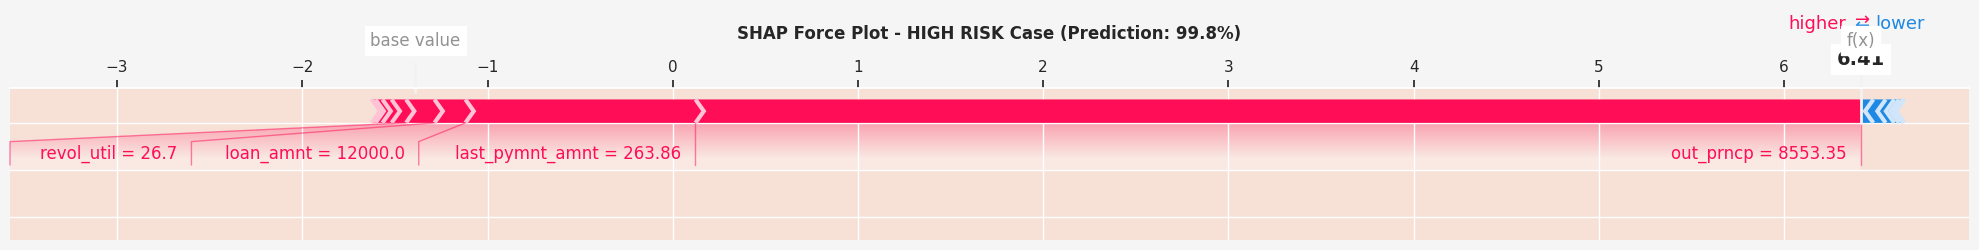


📈 Top 5 Features Pushing Prediction:
        Feature     Value  SHAP_Impact
      out_prncp   8553.35     6.290828
last_pymnt_amnt    263.86     1.242161
      loan_amnt  12000.00     0.167184
     revol_util     26.70     0.153525
    tot_cur_bal 205998.00     0.077914
CASE 2: BORDERLINE PREDICTION

📊 Prediction: 50.0% default probability
🎯 Actual outcome: DEFAULT (1)

📝 Loan Application Details:
  • loan_amnt      : 5750.00
  • int_rate       : 14.09
  • annual_inc     : 20000.00
  • dti            : 26.34
  • fico_score     : 682.00

🔍 SHAP Force Plot Breakdown:


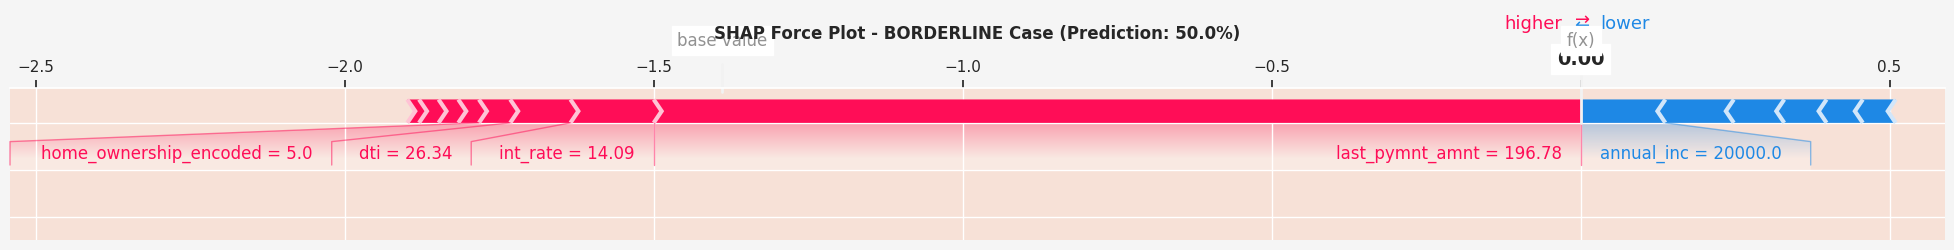


📈 Top 5 Features Pushing Prediction:
        Feature    Value  SHAP_Impact
last_pymnt_amnt   196.78     1.500294
     annual_inc 20000.00    -0.136763
       int_rate    14.09     0.134777
    tot_cur_bal 12464.00    -0.110725
            dti    26.34     0.097451
CASE 3: LOW RISK PREDICTION

📊 Prediction: 0.0% default probability
🎯 Actual outcome: PAID (0)

📝 Loan Application Details:
  • loan_amnt      : 10000.00
  • int_rate       : 5.32
  • annual_inc     : 50000.00
  • dti            : 20.16
  • fico_score     : 787.00

🔍 SHAP Force Plot Breakdown:


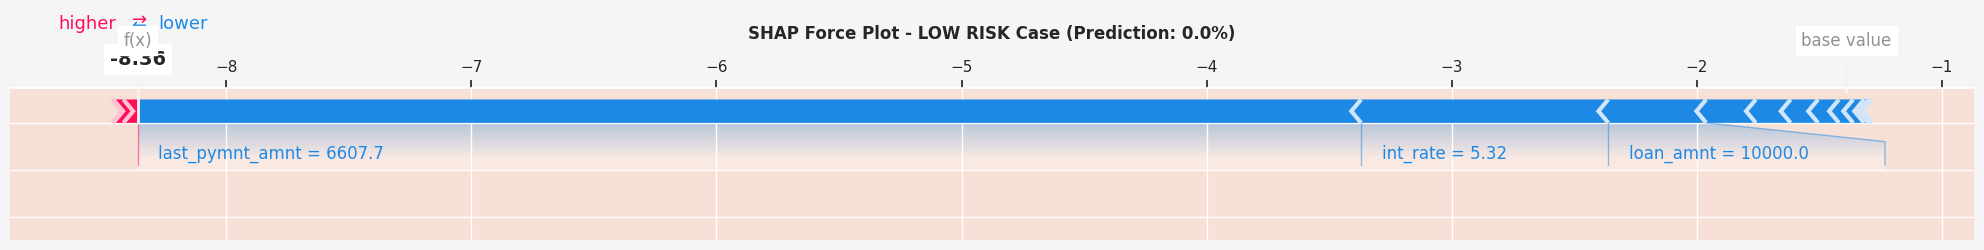


📈 Top 5 Features Pushing Prediction:
         Feature    Value  SHAP_Impact
 last_pymnt_amnt  6607.70    -4.992792
        int_rate     5.32    -1.008615
       loan_amnt 10000.00    -0.399708
      fico_score   787.00    -0.202514
total_rev_hi_lim 29400.00    -0.141750


In [25]:
print("INDIVIDUAL PREDICTION EXPLANATIONS")

# Select interesting cases to explain
# 1. Highrisk prediction (default)
# 2. Low risk prediction (paid)
# 3. Borderline case

# Get predictions for test sample
y_pred_proba_sample = trained_models['XGBoost'].predict_proba(X_test_sample)[:, 1]

# Find interesting cases
high_risk_idx = np.argmax(y_pred_proba_sample)  # Highest default probability
low_risk_idx = np.argmin(y_pred_proba_sample)    # Lowest default probability  
borderline_idx = np.argmin(np.abs(y_pred_proba_sample - 0.5))  # Closest to 50%

interesting_cases = [
    (high_risk_idx, "HIGH RISK", y_pred_proba_sample[high_risk_idx]),
    (borderline_idx, "BORDERLINE", y_pred_proba_sample[borderline_idx]),
    (low_risk_idx, "LOW RISK", y_pred_proba_sample[low_risk_idx])
]

print(f"\n📋 Selected Cases for Analysis:\n")
for idx, label, prob in interesting_cases:
    actual_status = "DEFAULT" if y_test.iloc[idx] == 1 else "PAID"
    print(f"  {label:12s} - Predicted: {prob:.1%} | Actual: {actual_status}")

# Generate force plots for each case
for case_idx, (idx, label, prob) in enumerate(interesting_cases, 1):
    print(f"CASE {case_idx}: {label} PREDICTION")
    
    # Get instance details
    instance = X_test_sample.iloc[idx]
    actual_label = "DEFAULT (1)" if y_test.iloc[idx] == 1 else "PAID (0)"
    
    print(f"\n📊 Prediction: {prob:.1%} default probability")
    print(f"🎯 Actual outcome: {actual_label}")
    print(f"\n📝 Loan Application Details:")
    
    # Show key features
    key_features_to_show = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_score']
    for feat in key_features_to_show:
        if feat in instance.index:
            print(f"  • {feat:15s}: {instance[feat]:.2f}")
    
    # Create matplotlib force plot
    print(f"\n🔍 SHAP Force Plot Breakdown:")
    
    try:
        shap.force_plot(
            explainers_dict['XGBoost'].expected_value,
            shap_values_dict['XGBoost'][idx],
            X_test_sample.iloc[idx],
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot - {label} Case (Prediction: {prob:.1%})', 
                 fontsize=12, fontweight='bold', pad=15)
        plt.tight_layout()
        plt.show()
    except:
        # Fallback to waterfall plot if force plot fails
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values_dict['XGBoost'][idx],
                base_values=explainers_dict['XGBoost'].expected_value,
                data=X_test_sample.iloc[idx],
                feature_names=final_features
            ),
            max_display=10,
            show=True
        )
    
    # Show top contributing features
    feature_contributions = pd.DataFrame({
        'Feature': final_features,
        'Value': instance.values,
        'SHAP_Impact': shap_values_dict['XGBoost'][idx]
    }).sort_values('SHAP_Impact', key=abs, ascending=False)
    
    print(f"\n📈 Top 5 Features Pushing Prediction:")
    print(feature_contributions.head(5).to_string(index=False))




### KEY INSIGHTS FROM INDIVIDUAL CASES


💡 What Force Plots Reveal:

1. **Feature Interactions**: How features combine to influence predictions
2. **Decision Transparency**: Clear view of which features drove each decision  
3. **Model Behavior**: Consistent with global SHAP analysis (last_pymnt_amnt dominates)
4. **Explainability**: Ability to explain specific decisions to stakeholders

⚠️ **Critical Observation:**
Even in individual predictions, leakage features (last_pymnt_amnt, out_prncp) 
dominate, confirming our data leakage concerns.


<a id="9"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🎓 9. Bias Detection</div>
 

Even if we don't have sensitive attributes like gender or marital status in this dataset, we can examine whether features are serving as proxies for protected characteristics.

**What We're Looking For:**
- Unexplained prediction gaps across categories
- Features that might correlate with protected attributes
- Patterns that aren't justified by legitimate risk factors

Note: Bias can hide in plain sight through proxy variables.


In [26]:
# Bias Detection: Feature Group Patterns Using SHAP + Predictions
model_name = 'XGBoost'

# Combine SHAP values with model predictions
shap_col_names = [f'{col}_shap' for col in final_features]
shap_df = pd.DataFrame(shap_values_dict[model_name], columns=shap_col_names)
shap_df['prediction'] = trained_models[model_name].predict_proba(X_test_sample)[:, 1]

# Merge features with predictions into a single DataFrame
analysis_df = X_test_sample.reset_index(drop=True).copy()
analysis_df['prediction'] = shap_df['prediction'].values

print("Bias Detection Analysis\n")

# Group analysis by home ownership
print("Average predictions by Home Ownership:")
home_shap_analysis = (analysis_df.groupby('home_ownership_encoded').agg({'int_rate': 'mean', 'fico_score': 'mean', 'prediction': 'mean'}).reset_index().round(4))
print(home_shap_analysis)
print("\nDo prediction differences reflect actual financial indicators?\n")

# Group analysis by loan purpose
print("Average predictions by Loan Purpose:")
purpose_analysis = (
    analysis_df.groupby('purpose_encoded')
    .agg({'int_rate': 'mean', 'fico_score': 'mean', 'prediction': 'mean'})
    .reset_index()
    .round(4)
)
print(purpose_analysis.head(10))
print("\nDo these prediction patterns align with risk profiles?")



Bias Detection Analysis

Average predictions by Home Ownership:
   home_ownership_encoded  int_rate  fico_score  prediction
0                       1   12.8667    701.0535      0.1720
1                       4   14.4727    702.9322      0.2560
2                       5   14.1532    693.4899      0.2523

Do prediction differences reflect actual financial indicators?

Average predictions by Loan Purpose:
   purpose_encoded  int_rate  fico_score  prediction
0                0   12.0400    717.0000      0.1539
1                1   11.4288    700.2710      0.2261
2                2   14.1338    695.2155      0.2172
3                4   13.1978    712.2500      0.2017
4                5    9.4400    667.0000      0.0008
5                6   11.4791    722.9091      0.0950
6                7   16.3843    692.0000      0.1174
7                8   12.6433    691.1667      0.1817
8                9   17.0462    695.1250      0.2515
9               11   11.6700    714.5000      0.3155

Do these p

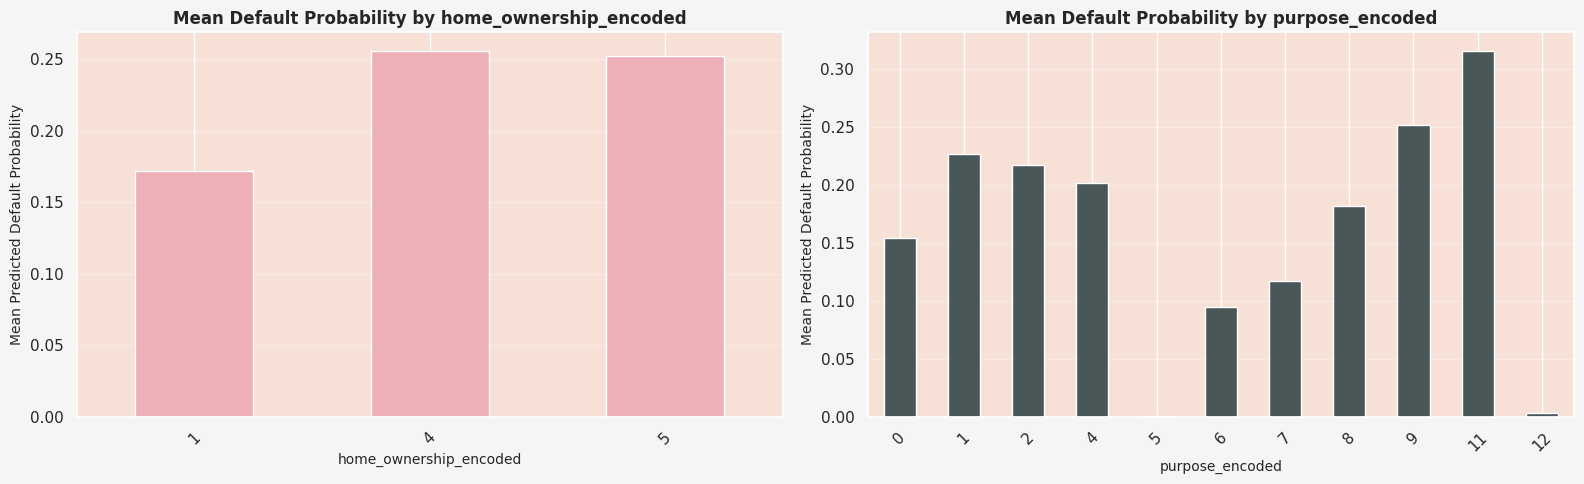


Always verify: Are these differences justified by legitimate risk factors?


In [27]:
# Visualize potential bias patterns 
categorical_encoded = [col for col in final_features if '_encoded' in col]

if len(categorical_encoded) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot first categorical feature
    if categorical_encoded[0] in analysis_df.columns:
        try:
            # Get column and ensure it's 1-dimensional
            cat1_col = analysis_df[categorical_encoded[0]]
            if isinstance(cat1_col, pd.DataFrame):
                cat1_col = cat1_col.iloc[:, 0]
            
            cat1_analysis = analysis_df.groupby(cat1_col)['prediction'].mean()
            cat1_analysis.plot(kind='bar', ax=axes[0], color= palette[0])
            axes[0].set_title(f'Mean Default Probability by {categorical_encoded[0]}', 
                             fontsize=12, fontweight='bold')
            axes[0].set_xlabel(f'{categorical_encoded[0]}', fontsize=10)
            axes[0].set_ylabel('Mean Predicted Default Probability', fontsize=10)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
            axes[0].grid(alpha=0.3, axis='y')
        except Exception as e:
            axes[0].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                        ha='center', va='center', transform=axes[0].transAxes)
    
    # Plot second categorical feature
    if categorical_encoded[1] in analysis_df.columns:
        try:
            # Get column and ensure it's 1-dimensional
            cat2_col = analysis_df[categorical_encoded[1]]
            if isinstance(cat2_col, pd.DataFrame):
                cat2_col = cat2_col.iloc[:, 0]
            
            cat2_analysis = analysis_df.groupby(cat2_col)['prediction'].mean()
            cat2_analysis.plot(kind='bar', ax=axes[1], color= palette[-1])
            axes[1].set_title(f'Mean Default Probability by {categorical_encoded[1]}', 
                             fontsize=12, fontweight='bold')
            axes[1].set_xlabel(f'{categorical_encoded[1]}', fontsize=10)
            axes[1].set_ylabel('Mean Predicted Default Probability', fontsize=10)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
            axes[1].grid(alpha=0.3, axis='y')
        except Exception as e:
            axes[1].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                        ha='center', va='center', transform=axes[1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAlways verify: Are these differences justified by legitimate risk factors?")
    
elif len(categorical_encoded) == 1:
    # Plot single categorical feature
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # Get column and ensure it's 1-dimensional
    cat_col = analysis_df[categorical_encoded[0]]
    if isinstance(cat_col, pd.DataFrame):
        cat_col = cat_col.iloc[:, 0]
                            
    cat_analysis = analysis_df.groupby(cat_col)['prediction'].mean()
    cat_analysis.plot(kind='bar', ax=ax, color= palette[0])
    ax.set_title(f'Mean Default Probability by {categorical_encoded[0]}',fontsize=12, fontweight='bold')
    ax.set_xlabel(f'{categorical_encoded[0]}', fontsize=10)
    ax.set_ylabel('Mean Predicted Default Probability', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
                            
    print("\nAlways verify: Are these differences justified by legitimate risk factors?")


<a id="10"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🎯 10. Conclusion</div>


<div style="background-color: #f7e1d7; padding: 20px; border-radius: 10px; border-left: 5px solid #4a5759; margin: 20px 0;">
<strong>🎓 The Central Lesson:</strong> This notebook demonstrated how a model with <strong>94.6% AUC</strong> hid fundamental flaws. Without SHAP explainability, we would have deployed a model that learned nothing about genuine credit risk, it simply memorised: low last payment = default.
</div>

## 📊 What We Learned

This notebook explored model explainability in credit risk, revealing critical insights that performance metrics alone could never show:

### 🚨 **Data Leakage Detection**
- **Finding**: `last_pymnt_amnt` accounted for **>65%** of total SHAP importance
- **Impact**: Removing leakage features caused **23% AUC drop** (94.6% → 72.6%)
- **Reality Check**: Clean model showed our TRUE predictive power at application time

### 🔍 **Feature Dominance Quantification**
- **Gini Coefficient**: Measured feature importance inequality
- **Visualisation**: Pie charts and bar plots revealed extreme concentration
- **Warning System**: Automated alerts for features exceeding dominance thresholds

### 🧪 **Fragility Testing**
- **Method**: Removed the top SHAP feature and retrained
- **Result**: Severe performance collapse confirmed over-reliance
- **Lesson**: High accuracy + high fragility = unreliable model

### 💡 **Individual Prediction Analysis**
- **SHAP Force Plots**: Showed how features push predictions for specific cases
- **Transparency**: Ability to explain exact reasoning for each decision
- **Pattern Confirmation**: Local explanations matched global feature dominance


## 🎓 Key Lessons

<div style="background-color: #f7e1d7; padding: 20px; border-radius: 10px; border-left: 5px solid #b0c4b1; margin: 20px 0;">

### 📌 **1. High Metrics Don't Guarantee Model Quality**
- 94.6% AUC looked perfect but hid critical flaws
- Always ask: "What did the model actually learn?"
- SHAP reveals the **why** behind the **how well**

### 📌 **2. Data Leakage is Common in Real-World Datasets**  
- Post-outcome features sneak into feature sets easily
- Look for keywords: `last_`, `total_`, `pymnt`, `rec_`
- Compare model performance with/without suspicious features

### 📌 **3. Feature Dominance Indicates Problems**
- Single feature >50% importance = investigate immediately
- Calculate Gini coefficient to measure inequality
- Balanced models are more robust and interpretable

### 📌 **4. Test Model Fragility, Not Just Accuracy**
- Remove top features and retrain
- Performance drop >10% = concerning dependency
- Performance drop >20% = severe over-reliance

### 📌 **5. Combine Global and Local Explanations**
- **Global SHAP**: Overall feature importance patterns
- **Force Plots**: Individual prediction breakdowns
- **Dependence Plots**: Feature relationship dynamics

</div>



## 🎯 Final Thoughts

> **"A model you cannot explain is a model you cannot trust."**

This notebook showed that:
-  Accuracy without understanding is dangerous
-  SHAP reveals what models actually learn
-  Explainability prevents costly production failures
-  Transparency builds stakeholder trust

The goal isn't just to build models that perform well on test sets. The goal is to build models that:
- Make decisions for the **right reasons**
- Are **robust** to feature removal
- Are **transparent** to stakeholders
- Are **fair** across demographics
- Are **trustworthy** in production




## 📚 Explore the Complete Series

This comparison is part of a three-notebook explainability series:

📘 **[Notebook 1: Credit Risk with SHAP](https://www.kaggle.com/code/karnikakapoor/credit-risk-explainability-shap)** **(You are here!)**  
📗 **[Notebook 2: Medical Insurance with LIME](https://www.kaggle.com/code/karnikakapoor/medical-insurance-cost-with-lime#notebook-container)** Local explanations, reliability assessment, edge cases  
📙 **[Notebook 3: SHAP vs LIME](https://www.kaggle.com/code/karnikakapoor/shap-vs-lime-the-ultimate-comparison)** Direct comparison of SHAP vs LIME  

📝 **[Read the Full Write-up: Beyond Accuracy](https://www.kaggle.com/writeups/karnikakapoor/beyond-accuracy)** 


<div style="background:#4a5759; padding: 20px; border-radius: 10px; margin: 20px 0;">
    <p style="color: #edafb8; text-align: center; margin: 0; font-size: 1.2em;">
    <strong>END</strong>
    </p>
</div>